In [68]:
import gymnasium as gym
import numpy as np
import random
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import animation
from IPython.display import HTML
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report, accuracy_score

df = pd.read_csv("https://drive.google.com/uc?export=download&id=1_pw4LCjPX4md52edSi2WgsdJJxsYHkR0", delimiter=',')

var_to_keep = ['ClimbRate', 'Sgz', 'P', 'Q', 'CurPitch', 'CurRoll', 'AbsRoll', 'DiffClb', 'DiffRollRate', 'DiffDiffClb',
               'DiffSeTime1', 'DiffSeTime3', 'DiffSeTime5', 'DiffSeTime7', 'DiffSeTime9', 'DiffSeTime11', 'DiffSeTime13', 'Alpha', 'Se', 'Goal']
print(df.head())

   ClimbRate  Sgz     P     Q  CurPitch  CurRoll  AbsRoll  DiffClb  \
0        -17   -6 -0.03  0.14      0.59     -0.5      -11       -9   
1       -791   15 -0.28 -0.34      1.11      0.9      -10       27   
2        -46   48 -0.42  0.07      0.57      0.6       -5       -8   
3        496   -5 -0.21 -0.04      0.03     -0.5       -7        6   
4       -124   16 -0.02  0.05      0.61     -0.2       -9       -3   

   DiffRollRate  DiffDiffClb  ...  DiffSeTime8  DiffSeTime9  DiffSeTime10  \
0         0.015         -0.2  ...          0.0          0.0           0.0   
1        -0.002          4.7  ...          0.0          0.0           0.0   
2        -0.008          0.0  ...          0.0          0.0           0.0   
3        -0.002         -0.1  ...          0.0          0.0           0.0   
4         0.000          0.0  ...          0.0          0.0           0.0   

   DiffSeTime11  DiffSeTime12  DiffSeTime13  DiffSeTime14  Alpha     Se  \
0         0.000           0.0         0.0

In [ ]:
!pip install gymnasium

#### O Gymnasium, *aka* gym, é uma biblioteca derivada da gym do grupo OpenAI. Ela consiste em uma API que simula diversos ambientes de controle, jogos, ambientes 3D, etc... para que usuários possam aplicar técnicas de *Reinforcement Learning*

#### O objetivo desta prática é implementar uma solução de **Aprendizado por Reforço** para o *Cart Pole* que consiste em:
* Manter o pêndulo invertido orientado para cima - o ângulo do poste não deve ultrapassar o intervalo [-.2095, .2095] radianos
* O vagão deve se manter no trilho - sua posição em X deve se manter no intervalo [-2.4, 2.4]

#### Primeiramente vamos criar um ambiente do 'CartPole-v1', iniciar com o método reset() e interagir com o ambiente com alguns passos aleatórios.

<hr>

# *Cart Pole*
* https://gymnasium.farama.org/environments/classic_control/cart_pole/

In [ ]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
_ = env.reset()
frames = []
actions, rewards = [], []
done = False

while not done:
    frames.append(env.render())
    action = env.action_space.sample()
    state, reward, done, _, _ = env.step(action)
    actions.append(action)
    rewards.append(reward)

round4 = lambda x: round(x, 4)
print("Ações aleatorias:", actions, "\nRecompensa Imediata:", rewards, sep='\n')
print('\nEstado final:', 'Cart Position    |   Cart Velocity   |   Pole Angle  |   Pole Angular Velocity', sep='\n')
print(*map(round4, state), sep=" "*16)

Ações aleatorias:
[0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0]

Recompensa Imediata:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Estado final:
Cart Position    |   Cart Velocity   |   Pole Angle  |   Pole Angular Velocity
0.1327                1.0174                -0.2144                -1.6667


In [ ]:
def display_frames_as_gif(frames):

    plt.ioff()
    aspect = 72
    fig, ax = plt.subplots(figsize=(frames[0].shape[1] / aspect, frames[0].shape[0] / aspect), dpi=aspect)
    patch = ax.imshow(frames[0])
    _ = plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50, )
    return anim

anim = display_frames_as_gif(frames)
HTML(anim.to_jshtml())

# Sua implementação do *CartPole*

In [ ]:
env = gym.make('CartPole-v1', render_mode = 'rgb_array')

# Q-learning parameters
alpha = 0.1
gamma = 0.99

epsilon_zero = 1  # valor inicial de epsilon
epsilon_min = 0.01  # valor final de epsilon
episodes = 2500  # Numero maximo de episodios do treinamento. MAXIMO PERMITIDO 250_000
min_epsilon_episode = 1000 #Episodio que o epsilon mínimo é atingido

max_steps = 500  # Número máximo de passos no treinamento. Fixo!
epsilon = epsilon_zero
epsilon_decay = (epsilon_min - epsilon) / min_epsilon_episode  # Decaimento Linear do Epsilon, PERMITIDO ALTERAÇÕES


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
def discretize_state(state, bin_edges):
    """
    Converte o estado contínuo em um estado discreto com base nas bordas dos bins.
    """
    bin_edges = [
        np.linspace(-4.8, 4.8, bin_edges[0]),
        np.linspace(-5, 5, bin_edges[1]),
        np.linspace(-0.418, 0.418, bin_edges[2]),
        np.linspace(-5, 5, bin_edges[3])
    ]
    state_discrete = []
    for i in range(len(state)):
        state_discrete.append(np.digitize(state[i], bin_edges[i]) - 1)
    return tuple(state_discrete)

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros para o algoritmo Q-learning
learning_rate = 0.1  # Taxa de aprendizado
discount_factor = 0.99  # Fator de desconto
initial_exploration = 1.0  # Taxa de exploração inicial
final_exploration = 0.01  # Taxa de exploração mínima
exploration_decay = 0.995  # Taxa de decaimento da exploração
max_episodes = 2500  # Número máximo de episódios para treinamento
episodes = 2500

# Configuração do ambiente e tabela Q
env = gym.make('CartPole-v1')
num_actions = env.action_space.n
state_bins = [20] * len(env.observation_space.high)  # Número de bins para cada dimensão do estado
q_table = np.random.uniform(low=-1, high=1, size=(*state_bins, num_actions))

def discretize_state(state, bins):
    """
    Converte o estado contínuo em um estado discreto com base nas bordas dos bins.
    """
    state_discrete = []
    for i in range(len(state)):
        state_discrete.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(state_discrete)

def q_learning_training(env, q_table, episodes, alpha, gamma, epsilon, epsilon_min, epsilon_decay):
    """
    Treina o agente usando o algoritmo Q-learning.
    """
    reward_history = []
    epsilon_history = []

    # Define as bordas dos bins para discretizar o espaço de estados
    bin_edges = [
        np.linspace(-4.8, 4.8, state_bins[0]),
        np.linspace(-5, 5, state_bins[1]),
        np.linspace(-0.418, 0.418, state_bins[2]),
        np.linspace(-5, 5, state_bins[3])
    ]

    for episode in range(episodes):
        state, _ = env.reset()
        state_discrete = discretize_state(state, bin_edges)
        total_reward = 0

        done = False
        while not done:
            # Escolha da ação com base na política ε-greedy
            if np.random.random() < epsilon:
                action = np.random.choice(num_actions)  # Ação aleatória
            else:
                action = np.argmax(q_table[state_discrete])  # Ação com maior valor Q

            # Executa a ação no ambiente
            next_state, reward, done, _, _ = env.step(action)
            next_state_discrete = discretize_state(next_state, bin_edges)
            total_reward += reward

            if done and total_reward < 500:
                reward = -150  # Penalidade se o episódio terminar antes do objetivo

            # Atualiza o valor Q
            q_table[state_discrete][action] += alpha * (
                reward + gamma * np.max(q_table[next_state_discrete]) - q_table[state_discrete][action]
            )

            state_discrete = next_state_discrete

        reward_history.append(total_reward)
        epsilon_history.append(epsilon)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)  # Atualiza epsilon

    return reward_history, epsilon_history

# Executa o treinamento do agente
rewards, epsilon_values = q_learning_training(env, q_table, max_episodes, learning_rate, discount_factor, initial_exploration, final_exploration, exploration_decay)


In [ ]:
# Define the bins for each state variable
n_bins = 10 #TODO Escolha um número de estados para cada variável
bins = [
    np.linspace(-4.8, 4.8, n_bins), #Cart Position
    np.linspace(-4, 4, n_bins), #Cart Velocity
    np.linspace(-0.418, 0.418, n_bins), #Pole Angle
    np.linspace(-4, 4, n_bins) #Pole Angular Velocity
]

def discretize_state(state, bins):
    """
    Discretize a continuous state into discrete bins.

    Parameters:
    - state: list or tuple of continuous state variables
    - bins: list of arrays defining the bin edges for each state variable

    Returns:
    - state_discretized: tuple of discrete state indices
    """
    state_discretized = []
    for i, value in enumerate(state):
        # Use np.digitize to find the bin index
        bin_index = np.digitize(value, bins[i]) - 1
        # Ensure index is within bounds
        bin_index = max(0, min(bin_index, len(bins[i]) - 1))
        state_discretized.append(bin_index)

    return tuple(state_discretized)

# Inicialização da Q-table
state_space_size = tuple([len(bins[i]) + 1 for i in range(len(bins))])
action_space_size = env.action_space.n
Q = np.zeros(state_space_size + (action_space_size,))

In [ ]:
def choose_action(state, Q, epsilon):
    """
    Escolhe uma ação com base na política ε-greedy.

    Parameters:
    - state: estado atual discretizado
    - Q: tabela Q
    - epsilon: taxa de exploração

    Returns:
    - action: ação escolhida
    """
    if np.random.rand() < epsilon:
        # Escolha uma ação aleatória
        action = env.action_space.sample()
    else:
        # Escolha a ação com o maior valor Q para o estado atual
        action = np.argmax(Q[state])

    return action

def update_q_table(Q, state, action, reward, next_state, alpha, gamma):
    """
    Atualiza a Q-table usando a fórmula de Q-learning.

    Parameters:
    - Q: tabela Q
    - state: estado atual discretizado
    - action: ação tomada
    - reward: recompensa recebida
    - next_state: próximo estado discretizado
    - alpha: taxa de aprendizado
    - gamma: fator de desconto
    """
    best_next_action = np.argmax(Q[next_state])  # Ação com maior valor Q no próximo estado
    td_target = reward + gamma * Q[next_state][best_next_action]  # Alvo para a atualização
    td_error = td_target - Q[state][action]  # Erro de previsão
    Q[state][action] += alpha * td_error  # Atualização da tabela Q


In [ ]:
#Treinamento da Q-table
for episode in range(episodes):
    state, _ = env.reset()
    state = discretize_state(state, bins)
    total_reward = 0

    for step in range(max_steps):
        action = choose_action(state, Q, epsilon)
        next_state, reward, done, truncated, _ = env.step(action)
        next_state = discretize_state(next_state, bins)

        update_q_table(Q, state, action, reward, next_state, alpha, gamma)

        state = next_state
        total_reward += reward

        if done:
            break

    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon = epsilon_decay*episode + epsilon_zero

    print(f"Episode {episode + 1}: Total Reward = {total_reward}")

print("Training finished.\n")

Episode 1: Total Reward = 46.0
Episode 2: Total Reward = 15.0
Episode 3: Total Reward = 29.0
Episode 4: Total Reward = 23.0
Episode 5: Total Reward = 20.0
Episode 6: Total Reward = 19.0
Episode 7: Total Reward = 39.0
Episode 8: Total Reward = 19.0
Episode 9: Total Reward = 26.0
Episode 10: Total Reward = 11.0
Episode 11: Total Reward = 12.0
Episode 12: Total Reward = 20.0
Episode 13: Total Reward = 18.0
Episode 14: Total Reward = 13.0
Episode 15: Total Reward = 16.0
Episode 16: Total Reward = 31.0
Episode 17: Total Reward = 39.0
Episode 18: Total Reward = 25.0
Episode 19: Total Reward = 49.0
Episode 20: Total Reward = 28.0
Episode 21: Total Reward = 13.0
Episode 22: Total Reward = 40.0
Episode 23: Total Reward = 12.0
Episode 24: Total Reward = 14.0
Episode 25: Total Reward = 41.0
Episode 26: Total Reward = 27.0
Episode 27: Total Reward = 25.0
Episode 28: Total Reward = 17.0
Episode 29: Total Reward = 9.0
Episode 30: Total Reward = 25.0
Episode 31: Total Reward = 9.0
Episode 32: Total R

In [ ]:
frames = []

state, _ = env.reset()
state = discretize_state(state, bins)
total_reward = 0

for step in range(max_steps):

    frames.append(env.render())

    action = np.argmax(Q[state])
    next_state, reward, done, truncated, _  = env.step(action)
    next_state = discretize_state(next_state, bins)

    state = next_state
    total_reward += reward

    if done:
        break

print(f"Test Episode {episode + 1}: Total Reward = {total_reward}")

Test Episode 2500: Total Reward = 24.0


/usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


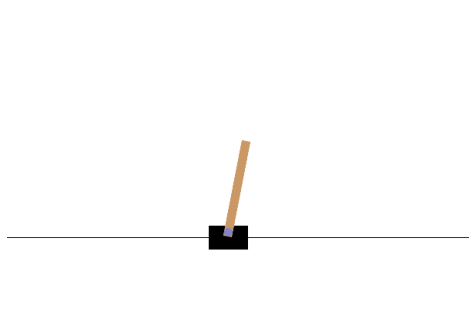

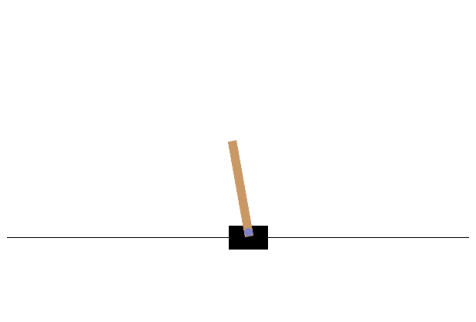

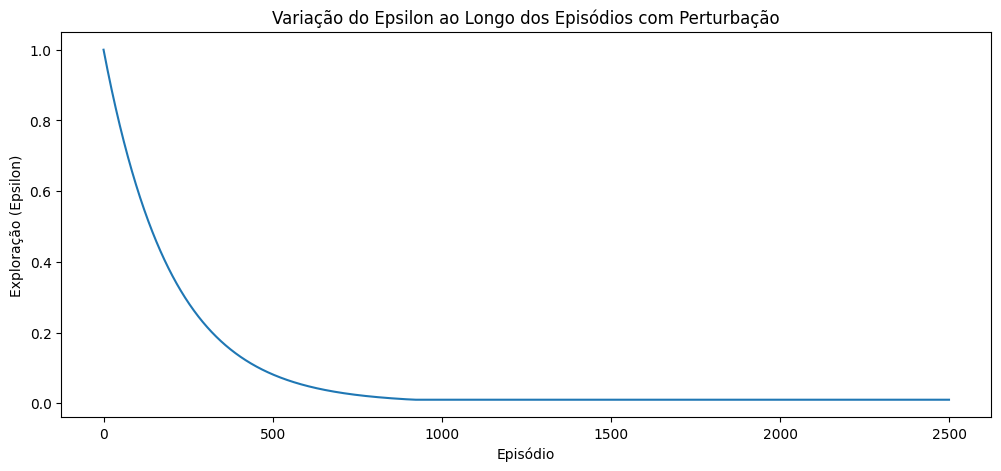

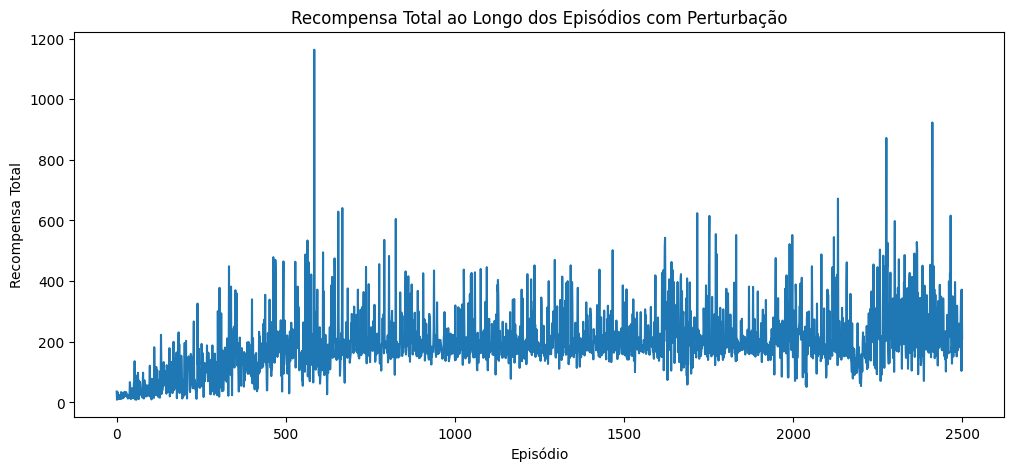

In [ ]:
def discretize_state(state, bins):
    """
    Converte o estado contínuo em um estado discreto com base nas bordas dos bins.
    """
    state_discrete = []
    for i in range(len(state)):
        state_discrete.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(state_discrete)

def add_perturbation(state, perturbation_strength=0.1):
    """
    Adiciona uma perturbação ao estado inicial do cartpole.
    """
    # Perturba o estado inicial adicionando uma pequena força ao cart
    perturbed_state = np.array(state) + np.random.uniform(-perturbation_strength, perturbation_strength, size=len(state))
    return perturbed_state

def q_learning_training(env, q_table, episodes, alpha, gamma, epsilon, epsilon_min, epsilon_decay, perturbation_strength):
    """
    Treina o agente usando o algoritmo Q-learning, com adição de perturbação ao estado inicial.
    """
    reward_history = []
    epsilon_history = []

    # Define as bordas dos bins para discretizar o espaço de estados
    bin_edges = [
        np.linspace(-4.8, 4.8, state_bins[0]),
        np.linspace(-5, 5, state_bins[1]),
        np.linspace(-0.418, 0.418, state_bins[2]),
        np.linspace(-5, 5, state_bins[3])
    ]

    for episode in range(episodes):
        state, _ = env.reset()
        state = add_perturbation(state, perturbation_strength)  # Aplica a perturbação
        state_discrete = discretize_state(state, bin_edges)
        total_reward = 0

        done = False
        while not done:
            # Escolha da ação com base na política ε-greedy
            if np.random.random() < epsilon:
                action = np.random.choice(num_actions)  # Ação aleatória
            else:
                action = np.argmax(q_table[state_discrete])  # Ação com maior valor Q

            # Executa a ação no ambiente
            next_state, reward, done, _, _ = env.step(action)
            next_state = add_perturbation(next_state, perturbation_strength)  # Aplica a perturbação
            next_state_discrete = discretize_state(next_state, bin_edges)
            total_reward += reward

            if done and total_reward < 500:
                reward = -150  # Penalidade se o episódio terminar antes do objetivo

            # Atualiza o valor Q
            q_table[state_discrete][action] += alpha * (
                reward + gamma * np.max(q_table[next_state_discrete]) - q_table[state_discrete][action]
            )

            state_discrete = next_state_discrete

        reward_history.append(total_reward)
        epsilon_history.append(epsilon)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)  # Atualiza epsilon

    return reward_history, epsilon_history

# Executa o treinamento do agente com perturbação
perturbation_strength = 0.1  # Força da perturbação aplicada ao estado
rewards, epsilon_values = q_learning_training(env, q_table, max_episodes, learning_rate, discount_factor, initial_exploration, final_exploration, exploration_decay, perturbation_strength)

# Gráfico da evolução do epsilon
plt.figure(figsize=(12, 5))
plt.plot(epsilon_values)
plt.xlabel('Episódio')
plt.ylabel('Exploração (Epsilon)')
plt.title('Variação do Epsilon ao Longo dos Episódios com Perturbação')
plt.show()

# Gráfico da recompensa total
plt.figure(figsize=(12, 5))
plt.plot(rewards)
plt.xlabel('Episódio')
plt.ylabel('Recompensa Total')
plt.title('Recompensa Total ao Longo dos Episódios com Perturbação')
plt.show()


# 1) Aprendizado Supervisionado - Regressão

A tripulação de um avião notou que o piloto automático não conseguia ajustar os ailerons
rapidamente, resultando em oscilações perigosas durante um voo transatlântico. Então uma
equipe de cientistas decidiu desenvolver um modelo de aprendizado de máquina, usando
dados históricos para prever a deflexão ideal dos ailerons. O objetivo era melhorar a
segurança e o conforto dos passageiros, ajustando automaticamente a deflexão dos ailerons
para o controle da rolagem da aeronave conforme condições variáveis de voo.

#### 1. Porque os atributos Alpha, Se e [SeTime1 : SeTime14] não contribuem em conjunto para um modelo?

  - A contribuição dos atributos Alpha, Se e [SeTime1: SeTime14] para um modelo pode não ser significativa em conjunto por várias razões. Vamos examinar algumas delas:

    1. Colinearidade: Quando várias variáveis são altamente correlacionadas entre si, uma ou mais podem não adicionar valor adicional ao modelo, já que elas contêm informações redundantes. Por exemplo, SeTime1, SeTime2, ..., SeTime14 podem estar fortemente correlacionadas entre si e com Se, reduzindo sua individualidade informativa.

    2. Relevância: Alpha (ângulo de ataque) e Se (deflexão da superfície de controle) podem não ser diretamente relevantes para prever a deflexão do aileron (Goal) quando comparados com variáveis mais diretamente ligadas à dinâmica de voo, como ClimbRate, Sgz, P, Q, etc.

    3. Ruído: As variáveis SeTime1, SeTime2, ..., SeTime14 podem introduzir mais ruído do que sinal se não forem bem representativas das mudanças relevantes para a previsão da deflexão do aileron.

    4. Sobreajuste: Incluir um grande número de variáveis pode levar ao sobreajuste, onde o modelo se ajusta muito bem aos dados de treinamento, mas não generaliza bem para novos dados. Diminuir o número de variáveis pode melhorar a capacidade de generalização do modelo.

    Para ilustrar isso, vamos fazer uma análise básica de colinearidade e correlação entre essas variáveis usando o dataset fornecido.

  - ### Análise de Colinearidade e Correlação

In [ ]:
# Selecionar as variáveis de interesse
variables = ['Alpha', 'Se'] + [f'SeTime{i}' for i in range(1, 15)] + ['Goal']

# Calcular a correlação entre as variáveis
correlation_matrix = df[variables].corr()

# Plotar a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação das Variáveis Selecionadas')
plt.show()

  Se observarmos uma alta correlação entre Alpha, Se e os tempos sequenciais, isso pode explicar porque eles não contribuem significativamente para o modelo quando usados juntos. Vamos também ver a relação deles com a variável alvo (Goal).

 - ### Verificação de Importância de Variáveis

In [ ]:
# Definir o modelo
model = LinearRegression()

# Selecionar todas as variáveis exceto 'Goal'
X = df.drop('Goal', axis=1)
y = df['Goal']

# Aplicar o RFE
selector = RFE(model, n_features_to_select=1, step=1)
selector = selector.fit(X, y)

# Ordenar as variáveis por importância
ranking = selector.ranking_
features = X.columns
feature_importance = pd.DataFrame({'Feature': features, 'Importance': ranking})
feature_importance = feature_importance.sort_values(by='Importance')

print(feature_importance)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


         Feature  Importance
17       SeTime8           1
18       SeTime9           2
31   DiffSeTime8           3
15       SeTime6           4
16       SeTime7           5
29   DiffSeTime6           6
12       SeTime3           7
11       SeTime2           8
25   DiffSeTime2           9
19      SeTime10          10
20      SeTime11          11
33  DiffSeTime10          12
27   DiffSeTime4          13
37  DiffSeTime14          14
21      SeTime12          15
22      SeTime13          16
35  DiffSeTime12          17
10       SeTime1          18
24   DiffSeTime1          19
23      SeTime14          20
39            Se          21
13       SeTime4          22
26   DiffSeTime3          23
14       SeTime5          24
32   DiffSeTime9          25
30   DiffSeTime7          26
8   DiffRollRate          27
34  DiffSeTime11          28
3              Q          29
28   DiffSeTime5          30
36  DiffSeTime13          31
2              P          32
5        CurRoll          33
38         Alp

 #### 2. Porque os atributos DiffSeTime[2i] para i de 1 a 7 tendem a não contribuir para o modelo?

 - Os atributos DiffSeTime[2i] para i de 1 a 7 (ou seja, DiffSeTime2, DiffSeTime4, DiffSeTime6, DiffSeTime8, DiffSeTime10, DiffSeTime12, DiffSeTime14) podem não contribuir significativamente para o modelo por algumas razões possíveis, como:

  1. Colinearidade: Esses atributos podem estar altamente correlacionados com outros atributos ou entre si, adicionando pouca informação nova ao modelo.

  2. Relevância: Eles podem não ser diretamente relevantes para a variável alvo (Goal) comparado a outras variáveis.

  3. Ruído: Podem adicionar mais ruído do que sinal ao modelo.
  
  4. Multicolinearidade: A presença de múltiplas variáveis altamente correlacionadas pode prejudicar o desempenho do modelo.

  Para verificar a importância desses atributos, podemos fazer uma análise de correlação e também usar um método de seleção de características.  
  
  Neste código, calculamos a matriz de correlação para as variáveis DiffSeTime[2i] e a variável alvo Goal para visualizar as correlações. Além disso, utilizamos a técnica de Recursive Feature Elimination (RFE) para verificar a importância relativa de todas as variáveis no dataset, incluindo os DiffSeTime.

  Isso permitirá identificar se as variáveis DiffSeTime[2i] são menos importantes e se elas não estão contribuindo significativamente para o modelo devido à colinearidade, irrelevância, ou outros fatores.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


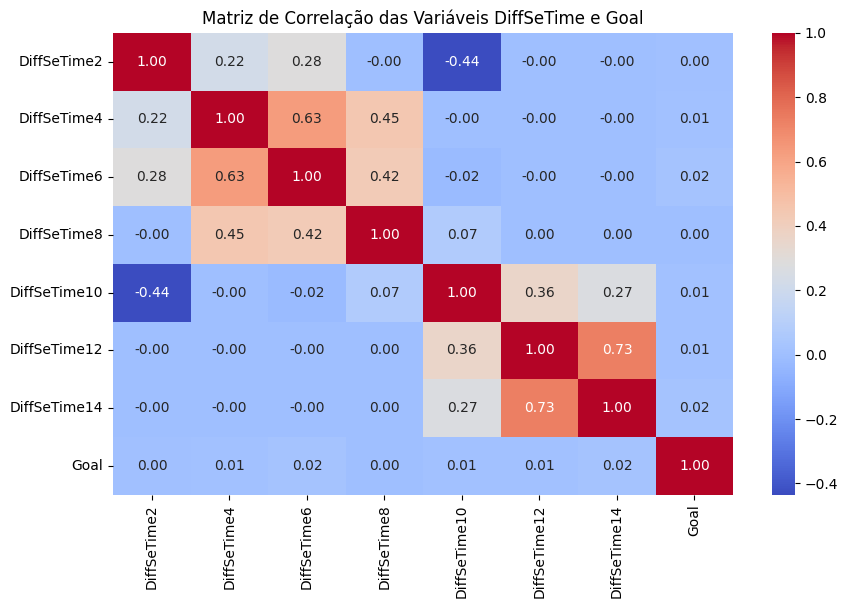

         Feature  Importance
17       SeTime8           1
18       SeTime9           2
31   DiffSeTime8           3
15       SeTime6           4
16       SeTime7           5
29   DiffSeTime6           6
12       SeTime3           7
11       SeTime2           8
25   DiffSeTime2           9
19      SeTime10          10
20      SeTime11          11
33  DiffSeTime10          12
27   DiffSeTime4          13
37  DiffSeTime14          14
21      SeTime12          15
22      SeTime13          16
35  DiffSeTime12          17
10       SeTime1          18
24   DiffSeTime1          19
23      SeTime14          20
39            Se          21
13       SeTime4          22
26   DiffSeTime3          23
14       SeTime5          24
32   DiffSeTime9          25
30   DiffSeTime7          26
8   DiffRollRate          27
34  DiffSeTime11          28
3              Q          29
28   DiffSeTime5          30
36  DiffSeTime13          31
2              P          32
5        CurRoll          33
38         Alp

In [ ]:
# Selecionar as variáveis de interesse
diff_setime_vars = [f'DiffSeTime{i}' for i in range(2, 15, 2)]

# Calcular a correlação entre as variáveis DiffSeTime e a variável alvo
correlation_matrix = df[diff_setime_vars + ['Goal']].corr()

# Plotar a matriz de correlação
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação das Variáveis DiffSeTime e Goal')
plt.show()

# Verificação de importância das variáveis usando RFE

# Definir o modelo
model = LinearRegression()

# Selecionar todas as variáveis exceto 'Goal'
X = df.drop('Goal', axis=1)
y = df['Goal']

# Aplicar o RFE
selector = RFE(model, n_features_to_select=1, step=1)
selector = selector.fit(X, y)

# Ordenar as variáveis por importância
ranking = selector.ranking_
features = X.columns
feature_importance = pd.DataFrame({'Feature': features, 'Importance': ranking})
feature_importance = feature_importance.sort_values(by='Importance')

print(feature_importance)

### 3. A partir desta questão utilize apenas as variáveis em instrucoes.txt. Observando uma matriz de correlação e pair_plots. Quais os atributos mais promissores para um modelo de predição Linear de Goal?

 - Para determinar quais atributos são mais promissores para um modelo de predição linear da variável alvo (Goal), podemos analisar a matriz de correlação e visualizar pair plots para identificar correlações fortes entre as variáveis independentes e a variável dependente.

  Vamos utilizar o código abaixo para carregar o dataset, filtrar as variáveis de interesse, calcular a matriz de correlação e plotar pair plots.

  #### Análise da Matriz de Correlação

  Na matriz de correlação, estamos interessados em encontrar as variáveis que têm uma alta correlação positiva ou negativa com a variável Goal. As variáveis com coeficientes de correlação próximos a 1 ou -1 são as mais promissoras para um modelo de predição linear, pois indicam uma relação linear forte com a variável alvo.

  ### Análise dos Pair Plots

  Os pair plots permitem visualizar as relações entre pares de variáveis, incluindo a variável alvo Goal. Eles ajudam a identificar relações lineares, tendências e padrões que podem não ser óbvios na matriz de correlação.

  ### Executando o Código

  Vamos executar o código acima para gerar a matriz de correlação e os pair plots. Isso nos permitirá identificar visualmente quais variáveis têm relações mais fortes com Goal e são mais promissoras para um modelo de predição linear.

  Após a execução, observaremos a matriz de correlação e os pair plots para identificar as variáveis mais promissoras. Normalmente, procuramos por coeficientes de correlação acima de 0.5 ou abaixo de -0.5 como bons indicadores de predição. Vamos fazer a análise dos resultados em seguida.

  ### Resultado

  Com base no código abaixo e no plot resultante, é possível dizer que os atributos mais promissores para um modelo de predição linear de Goal são:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


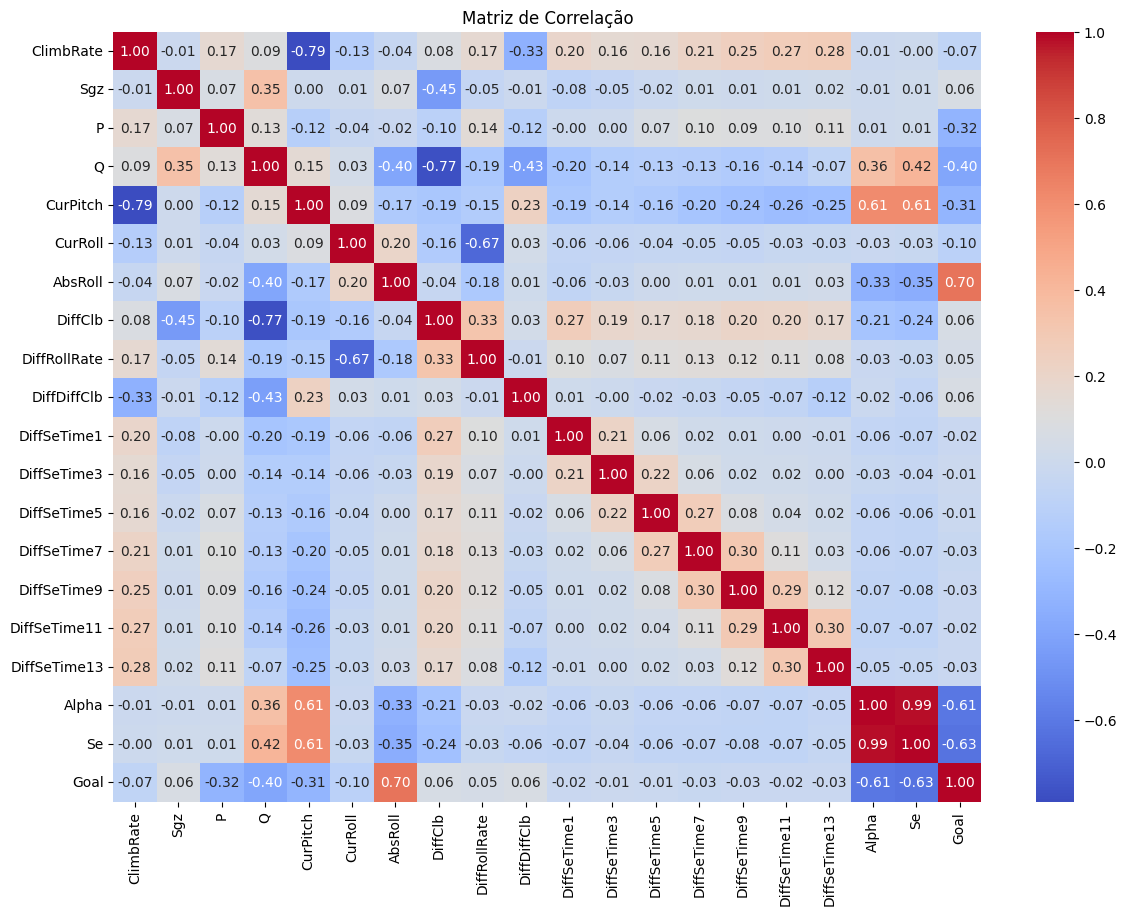

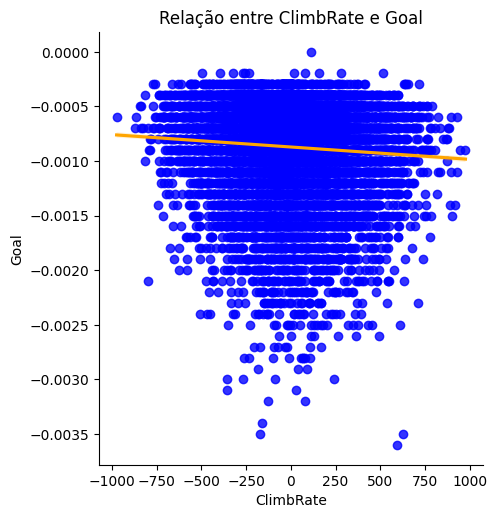

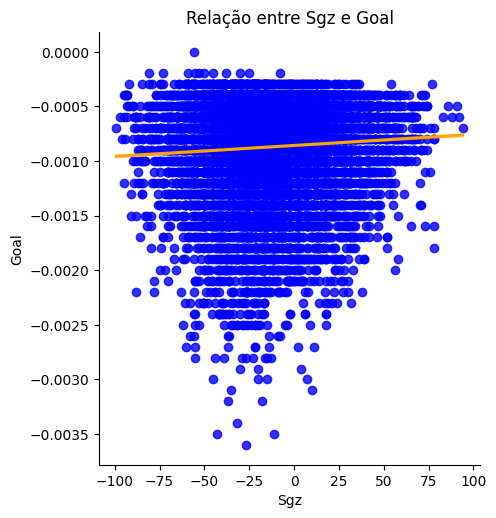

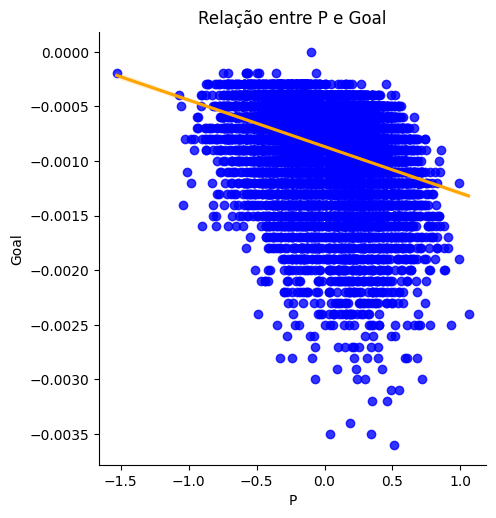

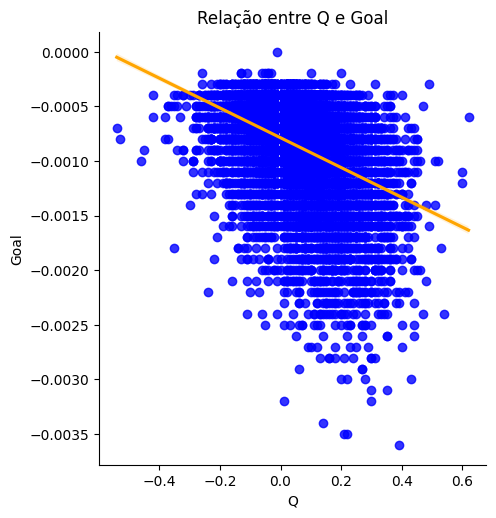

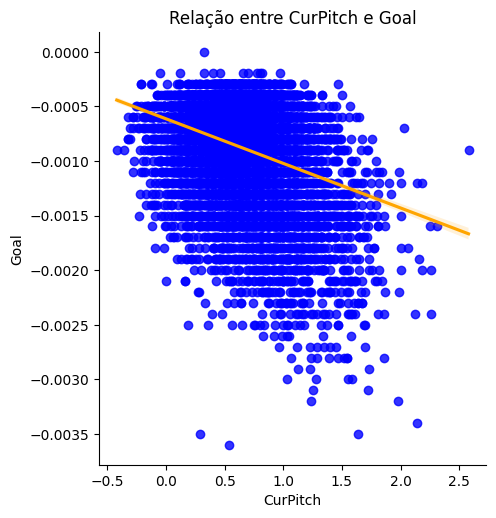

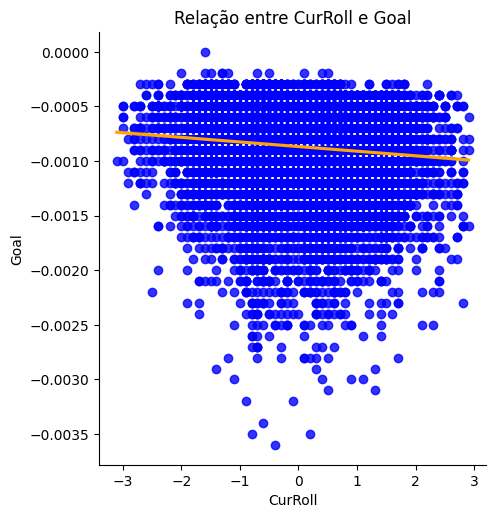

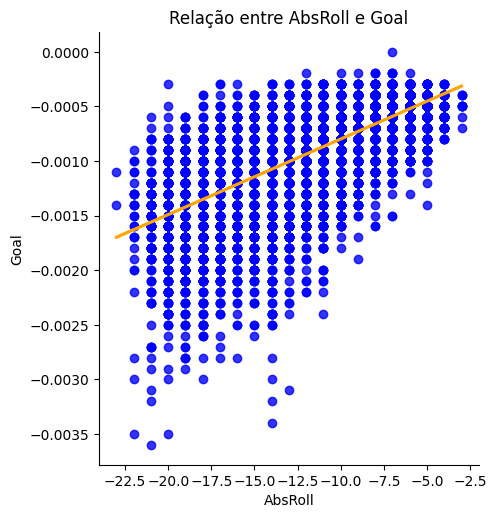

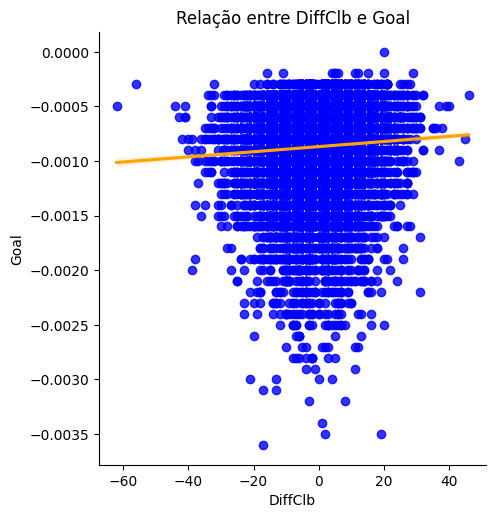

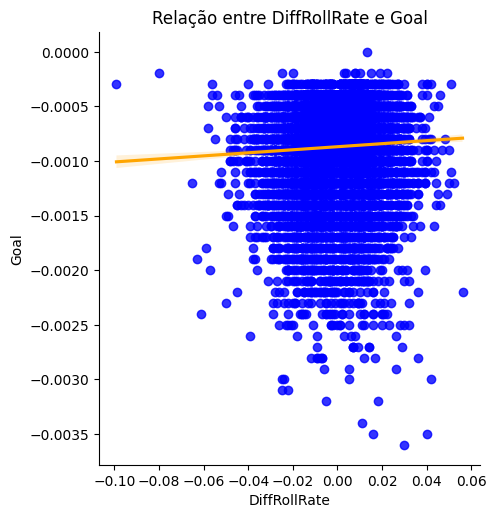

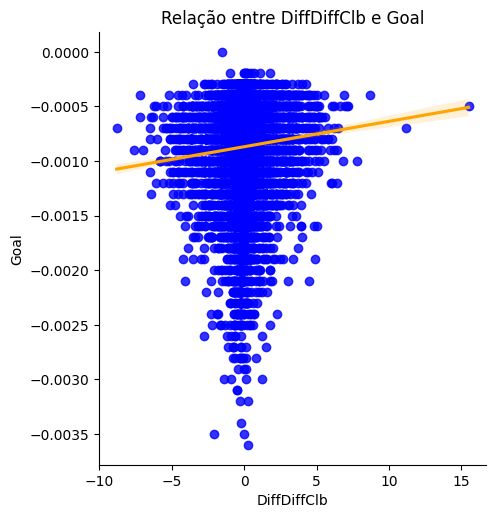

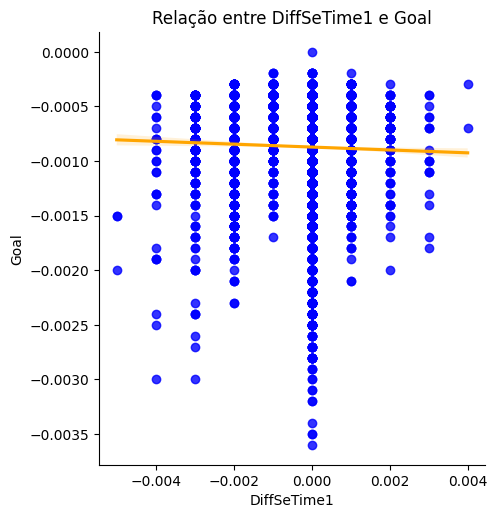

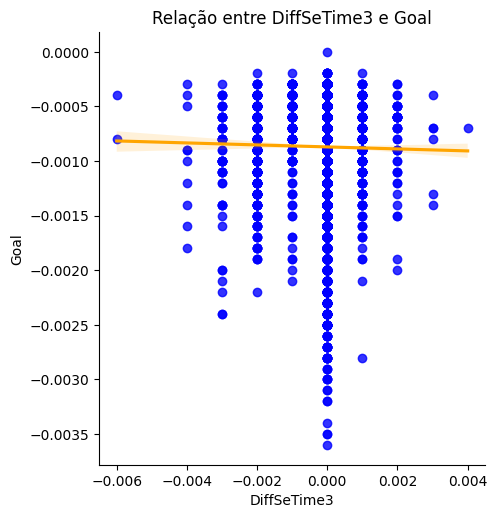

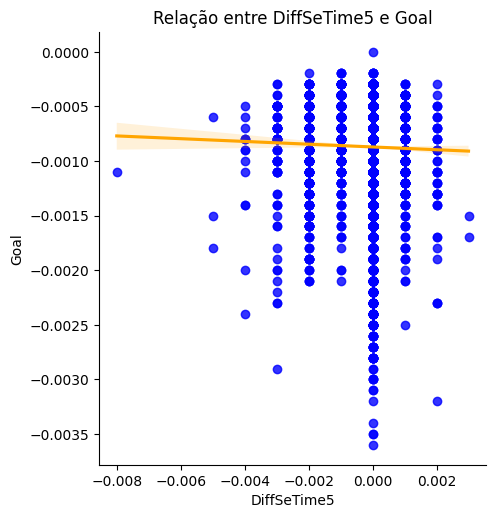

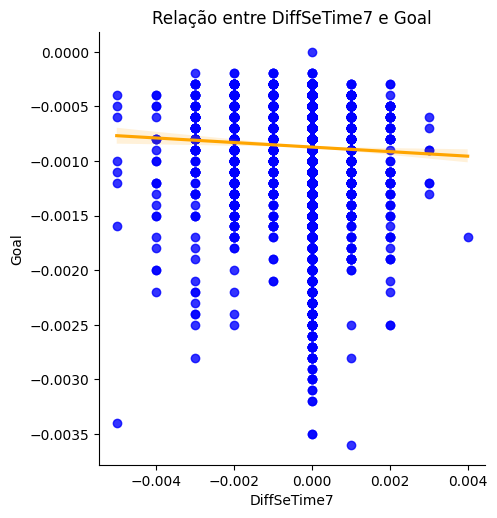

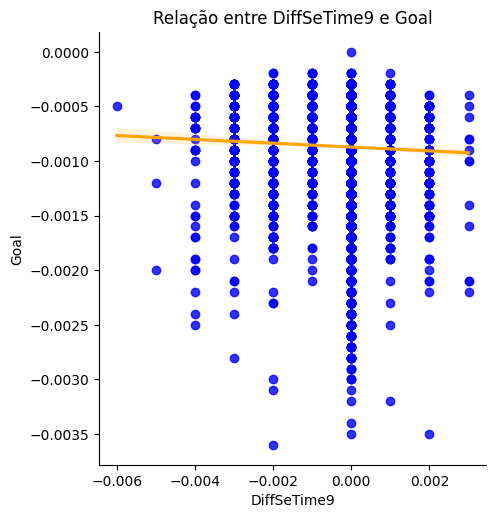

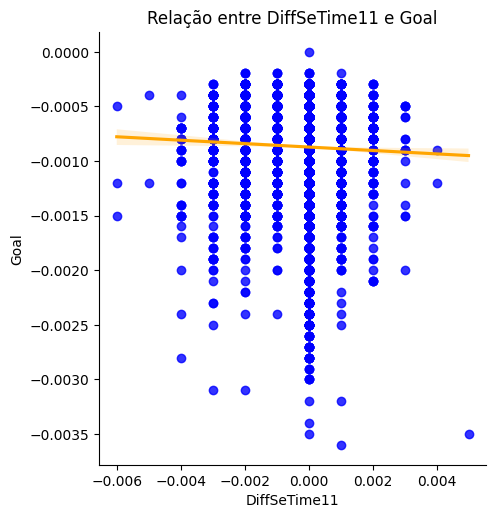

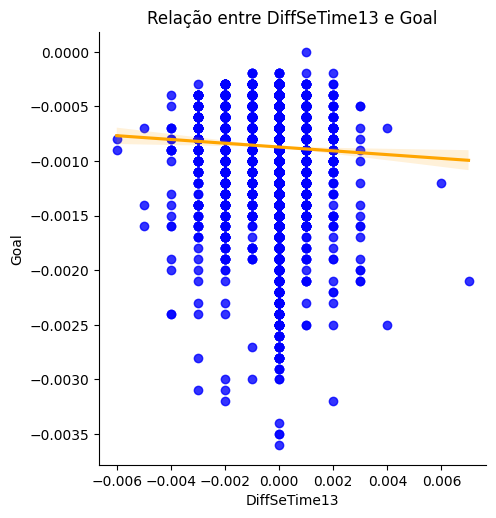

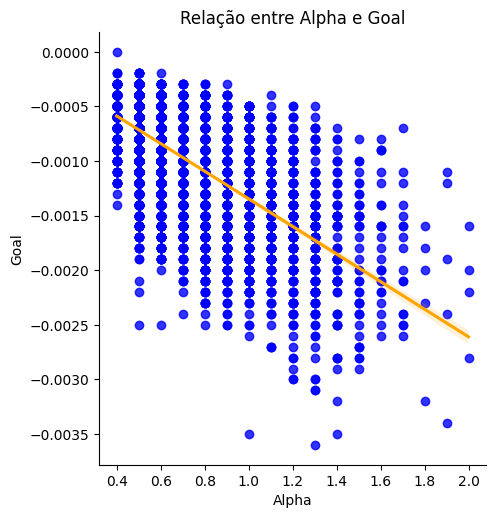

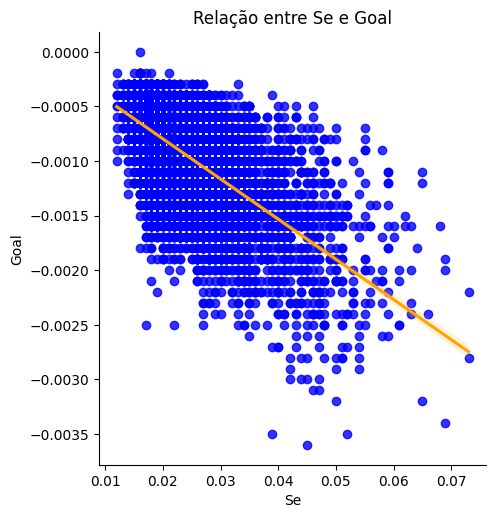

In [ ]:
# Filtrar o dataframe com as variáveis selecionadas
df_filtered = df[var_to_keep]

# Calcular a matriz de correlação
correlation_matrix = df_filtered.corr()

# Plotar a matriz de correlação
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

# Pair plots para cada variável em relação a Goal com linhas de intervalo de confiança em cor diferente
for var in var_to_keep[:-1]:  # Excluindo 'Goal' da lista
    pairplot = sns.pairplot(df_filtered, x_vars=var, y_vars='Goal', height=5, aspect=1, kind='reg',
                           plot_kws={'line_kws': {'color': 'orange'}, 'scatter_kws': {'color': 'blue'}})
    plt.title(f'Relação entre {var} e Goal')
    plt.show()

Considere um modelo de predição pontual da deflexão dos ailerons (Goal) e na **AUSÊNCIA** de qualquer atributo para 4 e 5:

 ### 4 e 5. Faça um histograma da variável resposta. Qual valor de Goal utilizaria para minimizar a métrica MAE? Qual valor de Goal utilizaria para minimizar a métrica MSE?

 - Para determinar o valor de Goal que minimiza as métricas MAE (Mean Absolute Error) e MSE (Mean Squared Error) na ausência de qualquer atributo, seguiremos o passo a passo:

  1. Plotar o histograma da variável Goal para entender sua distribuição.

  2. Calcular o valor de Goal que minimiza MAE e MSE usando a média e a mediana da distribuição. Em geral:
        - MAE: O valor que minimiza MAE é a mediana da variável resposta.
        - MSE: O valor que minimiza MSE é a média da variável resposta.

  ### Resposta:

  Valor de Goal que minimiza MAE: -0.0008
  
  Valor de Goal que minimiza MSE: -0.0008718690909090909
  
  MAE para a mediana: 0.0003034327272727273
  
  MSE para a média: 1.6629083377190083e-07

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


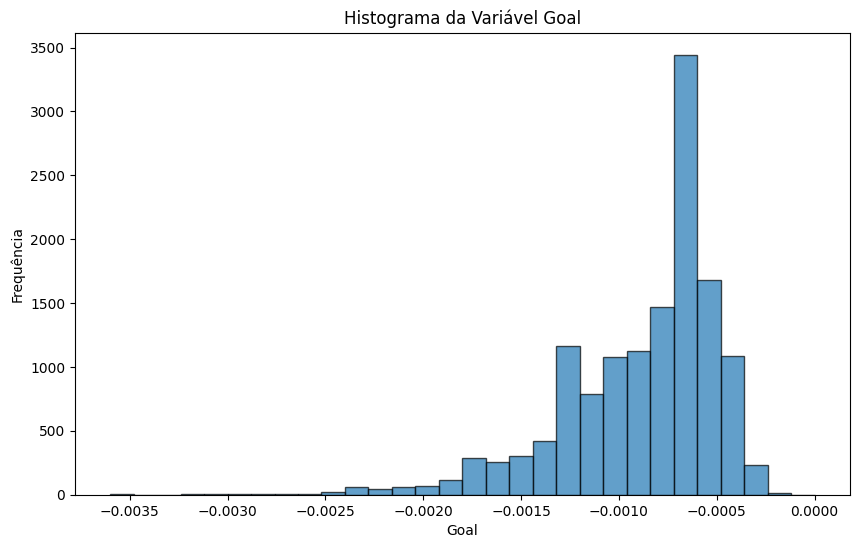

Valor de Goal que minimiza MAE: -0.0008
Valor de Goal que minimiza MSE: -0.0008718690909090909
MAE para a mediana: 0.0003034327272727273
MSE para a média: 1.6629083377190083e-07


In [ ]:
# Selecionar a variável de interesse
goal = df['Goal']

# Plotar o histograma da variável Goal
plt.figure(figsize=(10, 6))
plt.hist(goal, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Goal')
plt.ylabel('Frequência')
plt.title('Histograma da Variável Goal')
plt.show()

# Calcular a média e a mediana da variável Goal
mean_goal = goal.mean()
median_goal = goal.median()

# Calcular MAE e MSE usando a média e a mediana
mae_median = np.mean(np.abs(goal - median_goal))
mse_mean = np.mean((goal - mean_goal) ** 2)

print(f'Valor de Goal que minimiza MAE: {median_goal}')
print(f'Valor de Goal que minimiza MSE: {mean_goal}')
print(f'MAE para a mediana: {mae_median}')
print(f'MSE para a média: {mse_mean}')

### 6. O modelo de Regressão Linear minimiza qual tipo de erro?

#### - Resposta:

 O modelo de regressão linear minimiza o erro quadrático médio (MSE, Mean Squared Error).

 - Regressão Linear e MSE

  **Objetivo**
  
  O objetivo principal da regressão linear é encontrar a linha (ou plano, no caso de múltiplas variáveis) que melhor se ajusta aos dados. "Melhor se ajustar" é definido como a minimização da soma dos erros quadráticos.

  **Erro Quadrático**
  
  O erro quadrático é a diferença entre o valor observado e o valor predito, elevada ao quadrado. Isso assegura que os erros maiores tenham um impacto maior na minimização total.

  **Função Objetivo**
  
  Na regressão linear, a função objetivo é minimizar a soma dos quadrados dos erros (resíduos). A fórmula para o MSE é:

  MSE=1n∑i=1n(yi−y^i)2
  MSE=n1​i=1∑n​(yi​−y^​i​)2

  onde yiyi​ é o valor observado, y^iy^​i​ é o valor predito, e nn é o número de observações.

Ao minimizar o MSE, o modelo de regressão linear ajusta os parâmetros (coeficientes) para que a soma dos quadrados das diferenças entre os valores preditos e os valores reais seja a menor possível. Isso ajuda a garantir que o modelo faça previsões o mais próximo possível dos valores reais.

 - Comparação com MAE

   MAE (Mean Absolute Error) mede a média dos erros absolutos entre os valores preditos e os valores reais. É menos sensível a grandes discrepâncias do que o MSE, pois não eleva os erros ao quadrado.

Enquanto o MSE é a métrica que a regressão linear minimiza diretamente, o MAE pode ser usado como uma métrica alternativa para avaliar o desempenho do modelo, especialmente quando se deseja reduzir o impacto de valores extremos ou outliers.

### 7. Cite vantagens de utilizar o MAE o MSE e o RMSE em diferentes contextos.

**MAE (Mean Absolute Error)** é útil quando se deseja uma métrica que seja robusta a outliers e forneça uma interpretação direta do erro médio, pois é a média dos erros absolutos. É apropriado quando o impacto dos erros grandes não deve ser exagerado.

**MSE (Mean Squared Error)** é vantajoso quando se quer penalizar mais fortemente os erros grandes, já que os erros são elevados ao quadrado. Isso ajuda a identificar e mitigar grandes discrepâncias na predição, sendo útil quando se prioriza a redução dos grandes erros.

**RMSE (Root Mean Squared Error)** fornece uma métrica semelhante ao MSE, mas na mesma unidade da variável alvo, o que facilita a interpretação. É útil para problemas onde a magnitude dos erros deve ser considerada em unidades reais e é sensível a outliers, destacando a importância de reduzir grandes erros.

### 8. Elabore os seguintes modelos de regressão:

 - Regressão Linear

   - Espaço Hiperparâmetro: -

   

In [ ]:
X = df_filtered.drop('Goal', axis=1)
y = df_filtered['Goal']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar o modelo de Regressão Linear
model = LinearRegression()
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.00
R^2 Score: 0.83


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 - Ridge

   - Espaço Hiperparâmetro: alpha: {0.2, 1, 5}

  

In [ ]:
# Definir variáveis independentes (X) e variável dependente (y)
X = df_filtered.drop('Goal', axis=1)
y = df_filtered['Goal']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lista de valores para o hiperparâmetro alpha
alpha_values = [0.2, 1, 5]

# Armazenar os resultados para cada valor de alpha
results = []

for alpha in alpha_values:
    # Criar o modelo de Regressão Ridge com o valor de alpha
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)

    # Fazer previsões
    y_pred = model.predict(X_test)

    # Avaliar o modelo
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Alpha': alpha,
        'Mean Absolute Error (MAE)': mae,
        'Mean Squared Error (MSE)': mse,
        'Root Mean Squared Error (RMSE)': rmse,
        'R^2 Score': r2
    })

# Criar um DataFrame para exibir os resultados
results_df = pd.DataFrame(results)
print(results_df)

   Alpha  Mean Absolute Error (MAE)  Mean Squared Error (MSE)  \
0    0.2                   0.000130              3.047462e-08   
1    1.0                   0.000130              3.070554e-08   
2    5.0                   0.000131              3.103104e-08   

   Root Mean Squared Error (RMSE)  R^2 Score  
0                        0.000175   0.825625  
1                        0.000175   0.824304  
2                        0.000176   0.822441  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 - XGboost

   - Espaço Hiperparâmetro: instrucoes.txt

  

In [ ]:
# Definir variáveis independentes (X) e variável dependente (y)
X = df_filtered.drop('Goal', axis=1)
y = df_filtered['Goal']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lista de combinações de hiperparâmetros
params = [
    [50, 4, 0.2],
    [50, 10, 1],
    [50, 10, 0.2],
    [50, 10, 0.04],
    [200, 4, 1],
    [200, 4, 0.2],
    [200, 4, 0.04],
    [200, 10, 0.2]
]

# Armazenar os resultados para cada combinação de hiperparâmetros
results = []

for param in params:
    n_estimators, max_depth, learning_rate = param

    # Criar o modelo XGBoost com os parâmetros especificados
    model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, objective='reg:squarederror')
    model.fit(X_train, y_train)

    # Fazer previsões
    y_pred = model.predict(X_test)

    # Avaliar o modelo
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'Mean Absolute Error (MAE)': mae,
        'Mean Squared Error (MSE)': mse,
        'Root Mean Squared Error (RMSE)': rmse,
        'R^2 Score': r2
    })

# Criar um DataFrame para exibir os resultados
results_df = pd.DataFrame(results)
print(results_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   n_estimators  max_depth  learning_rate  Mean Absolute Error (MAE)  \
0            50          4           0.20                   0.000124   
1            50         10           1.00                   0.000140   
2            50         10           0.20                   0.000122   
3            50         10           0.04                   0.000134   
4           200          4           1.00                   0.000133   
5           200          4           0.20                   0.000124   
6           200          4           0.04                   0.000123   
7           200         10           0.20                   0.000122   

   Mean Squared Error (MSE)  Root Mean Squared Error (RMSE)  R^2 Score  
0              2.842438e-08                        0.000169   0.837356  
1              3.624974e-08                        0.000190   0.792580  
2              2.764970e-08                        0.000166   0.841789  
3              3.306033e-08                        0.000182

### 9. Observando os intervalos de confiança dos coeficientes da Regressão Linear, quais atributos devem ser descartados? (Use a biblioteca do statsmodels)

Para determinar quais atributos devem ser descartados com base nos intervalos de confiança dos coeficientes da Regressão Linear, você pode usar a biblioteca statsmodels para ajustar o modelo e calcular os intervalos de confiança dos coeficientes. A ideia é identificar os atributos cujos intervalos de confiança contêm o valor zero, o que sugere que eles não têm um efeito significativo sobre a variável resposta Goal.

Abaixo, está o passo a passo utilizado com o 'statsmodels':

  1. **Preparar os Dados**: Carregar e preparar o dataset.
  
  2. **Ajustar o Modelo**: Usar statsmodels para ajustar o modelo de Regressão Linear.
  
  3. **Calcular Intervalos de Confiança**: Obter os intervalos de confiança dos coeficientes e identificar os atributos que devem ser descartados.

In [ ]:
# Definir variáveis independentes (X) e variável dependente (y)
X = df_filtered.drop('Goal', axis=1)
y = df_filtered['Goal']

# Adicionar uma constante para o intercepto
X = sm.add_constant(X)

# Ajustar o modelo de Regressão Linear
model = sm.OLS(y, X).fit()

# Obter os intervalos de confiança dos coeficientes
conf = model.conf_int()
conf.columns = ['Lower Bound', 'Upper Bound']
conf['Coefficient'] = model.params

# Identificar atributos cujos intervalos de confiança incluem zero
conf['Includes Zero'] = (conf['Lower Bound'] <= 0) & (conf['Upper Bound'] >= 0)

print("Intervalos de Confiança dos Coeficientes:")
print(conf)

# Atributos a serem descartados (cujo intervalo de confiança inclui zero)
discarded_attributes = conf[conf['Includes Zero']].index.tolist()
print("\nAtributos a serem descartados:")
print(discarded_attributes)

Intervalos de Confiança dos Coeficientes:
               Lower Bound   Upper Bound   Coefficient  Includes Zero
const         3.263756e-04  3.573016e-04  3.418386e-04          False
ClimbRate     1.254342e-07  3.668911e-07  2.461626e-07          False
Sgz           8.252274e-08  3.474094e-07  2.149660e-07          False
P            -4.362747e-04 -4.161312e-04 -4.262029e-04          False
Q            -1.171325e-04  1.194501e-04  1.158787e-06           True
CurPitch      1.466709e-04  4.003732e-04  2.735220e-04          False
CurRoll      -9.052656e-05 -8.228571e-05 -8.640614e-05          False
AbsRoll       5.631329e-05  5.924649e-05  5.777989e-05          False
DiffClb      -4.575397e-06 -2.546736e-06 -3.561067e-06          False
DiffRollRate  2.216136e-03  2.857708e-03  2.536922e-03          False
DiffDiffClb  -6.102582e-06  4.801155e-06 -6.507135e-07           True
DiffSeTime1  -1.006182e-02 -9.272423e-04 -5.494530e-03          False
DiffSeTime3  -6.599556e-03  7.056551e-03  2.2849

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- Explicação

   - **Preparação dos Dados**: Carrega e filtra o dataset, definindo X (variáveis independentes) e y (variável dependente).

   - **Ajuste do Modelo**: Ajusta o modelo de Regressão Linear usando statsmodels e adiciona uma constante para o intercepto.

   - **Intervalos de Confiança**: Calcula os intervalos de confiança dos coeficientes e verifica quais intervalos incluem zero. Identifica os atributos cujos coeficientes não são estatisticamente significativos (ou seja, seus intervalos de confiança incluem zero).

Os atributos cujos intervalos de confiança incluem zero são considerados menos significativos e podem ser descartados, pois isso sugere que não há evidências estatísticas suficientes para afirmar que eles têm um efeito significativo sobre a variável Goal.

### 10. Compare os resultados da Regressão Linear e sua versão regularizada.

Comparar os resultados de um modelo de Regressão Linear com sua versão regularizada, como a Regressão Ridge, pode fornecer insights sobre a eficácia da regularização em melhorar a performance do modelo e lidar com problemas como a multicolinearidade. Aqui estão os passos para realizar essa comparação:

   - Construir e Avaliar os Modelos:
        - Regressão Linear: Ajustar o modelo e calcular as métricas de desempenho.

        - Regressão Ridge: Ajustar o modelo com diferentes valores de alpha e calcular as métricas de desempenho.

   - Comparar as Métricas de Desempenho:
        - Comparar MAE, MSE, RMSE e R² dos modelos para entender como a regularização afeta o desempenho.

   - Analisar os Coeficientes:
        - Comparar os coeficientes dos modelos para entender o impacto da regularização.

In [ ]:
# Definir variáveis independentes (X) e variável dependente (y)
X = df_filtered.drop('Goal', axis=1)
y = df_filtered['Goal']

# Adicionar uma constante para o intercepto (para o modelo statsmodels)
X_with_const = sm.add_constant(X)

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos e Hiperparâmetros
alpha_values = [0.2, 1, 5]

# Regressão Linear
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Regressão Ridge
ridge_results = []

for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    y_pred_ridge = ridge_model.predict(X_test)
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    rmse_ridge = np.sqrt(mse_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)

    ridge_results.append({
        'Alpha': alpha,
        'Mean Absolute Error (MAE)': mae_ridge,
        'Mean Squared Error (MSE)': mse_ridge,
        'Root Mean Squared Error (RMSE)': rmse_ridge,
        'R^2 Score': r2_ridge
    })

# Criar DataFrame para resultados Ridge
ridge_results_df = pd.DataFrame(ridge_results)

# Exibir resultados
print("Resultados da Regressão Linear:")
print(f"Mean Absolute Error (MAE): {mae_linear:.2f}")
print(f"Mean Squared Error (MSE): {mse_linear:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_linear:.2f}")
print(f"R^2 Score: {r2_linear:.2f}")

print("\nResultados da Regressão Ridge:")
print(ridge_results_df)

# Coeficientes e Intervalos de Confiança da Regressão Linear
linear_model_sm = sm.OLS(y, X_with_const).fit()
conf = linear_model_sm.conf_int()
conf.columns = ['Lower Bound', 'Upper Bound']
conf['Coefficient'] = linear_model_sm.params
conf['Includes Zero'] = (conf['Lower Bound'] <= 0) & (conf['Upper Bound'] >= 0)
print("\nIntervalos de Confiança dos Coeficientes da Regressão Linear:")
print(conf)

# Coeficientes da Regressão Ridge para diferentes alphas
for result in ridge_results:
    alpha = result['Alpha']
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    print(f"\nCoeficientes da Regressão Ridge (alpha={alpha}):")
    print(pd.Series(ridge_model.coef_, index=X.columns))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Resultados da Regressão Linear:
Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.00
R^2 Score: 0.83

Resultados da Regressão Ridge:
   Alpha  Mean Absolute Error (MAE)  Mean Squared Error (MSE)  \
0    0.2                   0.000130              3.047462e-08   
1    1.0                   0.000130              3.070554e-08   
2    5.0                   0.000131              3.103104e-08   

   Root Mean Squared Error (RMSE)  R^2 Score  
0                        0.000175   0.825625  
1                        0.000175   0.824304  
2                        0.000176   0.822441  

Intervalos de Confiança dos Coeficientes da Regressão Linear:
               Lower Bound   Upper Bound   Coefficient  Includes Zero
const         3.263756e-04  3.573016e-04  3.418386e-04          False
ClimbRate     1.254342e-07  3.668911e-07  2.461626e-07          False
Sgz           8.252274e-08  3.474094e-07  2.149660e-07          False
P            -4.362747e-04 -

### Explicação

   - Preparação dos Dados: Carrega e filtra o dataset, dividindo-o em conjuntos de treinamento e teste.

   - Construção dos Modelos: Ajusta um modelo de Regressão Linear e calcula as métricas de desempenho (MAE, MSE, RMSE, R²).Além disso, ajusta modelos de Regressão Ridge com diferentes valores de alpha e calcula as métricas de desempenho para cada um.

   - Comparação dos Resultados: Exibe as métricas de desempenho para o modelo de Regressão Linear e para cada modelo de Regressão Ridge.Os coeficientes e intervalos de confiança da Regressão Linear são apresentados, e compara os coeficientes da Regressão Ridge para diferentes valores de alpha.

### Interpretação dos Resultados

 - Regressão Linear: Pode ser mais suscetível a problemas como multicolinearidade e overfitting, especialmente se o número de variáveis é grande em relação ao número de amostras.

 - Regressão Ridge: A regularização pode reduzir a variância dos coeficientes, melhorando a generalização do modelo e mitigando problemas de multicolinearidade. Comparar as métricas de desempenho pode mostrar se a regularização ajuda a melhorar a precisão do modelo.

 - Coeficientes: Os coeficientes da Regressão Ridge serão geralmente menores em magnitude comparados aos da Regressão Linear, e a magnitude dos coeficientes pode variar com diferentes valores de alpha. Isso reflete o efeito da regularização no modelo.

Essa comparação permite avaliar a eficácia da regularização em melhorar o desempenho do modelo e lidar com problemas de ajuste.

### 11. Compare o efeito dos hiperparâmetros do XGBoost e seus resultados.

Para comparar o efeito dos hiperparâmetros do XGBoost e seus resultados, você deve ajustar o modelo com diferentes combinações de hiperparâmetros e avaliar o desempenho de cada configuração. Os principais hiperparâmetros a serem analisados são:

   - n_estimators: Número de árvores na floresta.
   - max_depth: Profundidade máxima de cada árvore.
   - learning_rate: Taxa de aprendizado (ou taxa de atualização dos pesos).

Passos para Comparação

   - Preparar os Dados: Carregar e dividir o dataset.
   - Construir e Avaliar os Modelos: Ajustar o modelo XGBoost com diferentes combinações de n_estimators, max_depth, e learning_rate.
   - Comparar os Resultados: Avaliar e comparar o desempenho de cada combinação.

In [ ]:
# Definir variáveis independentes (X) e variável dependente (y)
X = df_filtered.drop('Goal', axis=1)
y = df_filtered['Goal']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lista de combinações de hiperparâmetros
params = [
    [50, 4, 0.2],
    [50, 10, 1],
    [50, 10, 0.2],
    [50, 10, 0.04],
    [200, 4, 1],
    [200, 4, 0.2],
    [200, 4, 0.04],
    [200, 10, 0.2]
]

# Armazenar os resultados para cada combinação de hiperparâmetros
results = []

for param in params:
    n_estimators, max_depth, learning_rate = param

    # Criar o modelo XGBoost com os parâmetros especificados
    model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, objective='reg:squarederror')
    model.fit(X_train, y_train)

    # Fazer previsões
    y_pred = model.predict(X_test)

    # Avaliar o modelo
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'Mean Absolute Error (MAE)': mae,
        'Mean Squared Error (MSE)': mse,
        'Root Mean Squared Error (RMSE)': rmse,
        'R^2 Score': r2
    })

# Criar um DataFrame para exibir os resultados
results_df = pd.DataFrame(results)
print(results_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   n_estimators  max_depth  learning_rate  Mean Absolute Error (MAE)  \
0            50          4           0.20                   0.000124   
1            50         10           1.00                   0.000140   
2            50         10           0.20                   0.000122   
3            50         10           0.04                   0.000134   
4           200          4           1.00                   0.000133   
5           200          4           0.20                   0.000124   
6           200          4           0.04                   0.000123   
7           200         10           0.20                   0.000122   

   Mean Squared Error (MSE)  Root Mean Squared Error (RMSE)  R^2 Score  
0              2.842438e-08                        0.000169   0.837356  
1              3.624974e-08                        0.000190   0.792580  
2              2.764970e-08                        0.000166   0.841789  
3              3.306033e-08                        0.000182

Interpretação dos Resultados

   - n_estimators:
       - **Efeito**: O número de árvores no modelo. Um valor maior pode melhorar a performance, mas também pode aumentar o tempo de treinamento e risco de overfitting.
       - **Observação**: Compare o desempenho com diferentes valores para ver como a adição de mais árvores afeta o desempenho.

   - max_depth:
       - **Efeito**: A profundidade máxima de cada árvore. Árvores mais profundas podem modelar relações mais complexas, mas também podem causar overfitting.
       - **Observação**: Verifique o impacto de diferentes profundidades na performance e na capacidade de generalização do modelo.

   - learning_rate:
       - **Efeito**: A taxa de aprendizado controla a contribuição de cada árvore para a predição final. Valores menores tornam o treinamento mais robusto, mas requerem mais árvores para convergir.
       - **Observação**: Analise como diferentes taxas de aprendizado afetam o desempenho e a estabilidade do modelo.

Comparação

   - **Performance**: Compare MAE, MSE, RMSE e R² entre diferentes combinações de hiperparâmetros para identificar quais configurações produzem o melhor equilíbrio entre erro e complexidade do modelo.
   - **Estabilidade**: Observe como a performance varia com diferentes configurações para entender a robustez do modelo.

Essas comparações ajudam a ajustar os hiperparâmetros do XGBoost para melhorar a precisão do modelo e evitar overfitting, garantindo que ele seja bem generalizado para novos dados.

### 12. Utilize métrica de avaliação e compare os diferentes modelos de regressão na predição da deflexão dos ailerons.

Para comparar os diferentes modelos de regressão na predição da deflexão dos ailerons, vamos usar métricas de avaliação como MAE (Mean Absolute Error), MSE (Mean Squared Error), RMSE (Root Mean Squared Error) e R² (coeficiente de determinação). Aqui está um passo a passo para ajustar e avaliar os seguintes modelos:

  1. Regressão Linear
  2. Regressão Ridge (com diferentes valores de alpha)
  3. XGBoost (com diferentes combinações de hiperparâmetros)

In [ ]:
# Definir variáveis independentes (X) e variável dependente (y)
X = df_filtered.drop('Goal', axis=1)
y = df_filtered['Goal']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos e Hiperparâmetros

# 1. Regressão Linear
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# 2. Regressão Ridge
alpha_values = [0.2, 1, 5]
ridge_results = []

for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    y_pred_ridge = ridge_model.predict(X_test)
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    rmse_ridge = np.sqrt(mse_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)

    ridge_results.append({
        'Alpha': alpha,
        'Mean Absolute Error (MAE)': mae_ridge,
        'Mean Squared Error (MSE)': mse_ridge,
        'Root Mean Squared Error (RMSE)': rmse_ridge,
        'R^2 Score': r2_ridge
    })

# 3. XGBoost
params = [
    [50, 4, 0.2],
    [50, 10, 1],
    [50, 10, 0.2],
    [50, 10, 0.04],
    [200, 4, 1],
    [200, 4, 0.2],
    [200, 4, 0.04],
    [200, 10, 0.2]
]
xgboost_results = []

for param in params:
    n_estimators, max_depth, learning_rate = param
    xgb_model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, objective='reg:squarederror')
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)

    xgboost_results.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'Mean Absolute Error (MAE)': mae_xgb,
        'Mean Squared Error (MSE)': mse_xgb,
        'Root Mean Squared Error (RMSE)': rmse_xgb,
        'R^2 Score': r2_xgb
    })

# Criar DataFrame para resultados Ridge e XGBoost
ridge_results_df = pd.DataFrame(ridge_results)
xgboost_results_df = pd.DataFrame(xgboost_results)

# Exibir resultados
print("Resultados da Regressão Linear:")
print(f"Mean Absolute Error (MAE): {mae_linear:.2f}")
print(f"Mean Squared Error (MSE): {mse_linear:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_linear:.2f}")
print(f"R^2 Score: {r2_linear:.2f}")

print("\nResultados da Regressão Ridge:")
print(ridge_results_df)

print("\nResultados do XGBoost:")
print(xgboost_results_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Resultados da Regressão Linear:
Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.00
R^2 Score: 0.83

Resultados da Regressão Ridge:
   Alpha  Mean Absolute Error (MAE)  Mean Squared Error (MSE)  \
0    0.2                   0.000130              3.047462e-08   
1    1.0                   0.000130              3.070554e-08   
2    5.0                   0.000131              3.103104e-08   

   Root Mean Squared Error (RMSE)  R^2 Score  
0                        0.000175   0.825625  
1                        0.000175   0.824304  
2                        0.000176   0.822441  

Resultados do XGBoost:
   n_estimators  max_depth  learning_rate  Mean Absolute Error (MAE)  \
0            50          4           0.20                   0.000124   
1            50         10           1.00                   0.000140   
2            50         10           0.20                   0.000122   
3            50         10           0.04                  

#### Interpretação dos Resultados

  1. Regressão Linear: Oferece uma linha base para comparação com modelos mais complexos. O desempenho é medido por MAE, MSE, RMSE e R².

  2. Regressão Ridge: A regularização ajuda a controlar overfitting e multicolinearidade. Compare o desempenho dos diferentes valores de alpha para entender como a regularização afeta o modelo.

  3. XGBoost: Um modelo baseado em árvores que pode capturar interações complexas entre variáveis. Compare o desempenho para diferentes combinações de n_estimators, max_depth e learning_rate para identificar as melhores configurações.

Comparar essas métricas para os diferentes modelos ajudará a entender qual modelo oferece a melhor performance na predição da deflexão dos ailerons e qual configuração de hiperparâmetros otimiza o desempenho.

# 2) Aprendizado Supervisionado - Classificação

Observou-se que uma estratégia discreta de atuação dos ailerons permitia maior conforto durante o voo. Faça a discretização das variáveis conforme instrucoes.txt para elaborar modelos de classificação.

Para realizar a discretização das variáveis e elaborar um modelo de classificação usando Regressão Logística, siga os passos abaixo:
Passos para Discretização e Criação do Modelo

  1. Discretização das Variáveis
  2. Preparação dos Dados para Classificação
  3. Criação e Avaliação do Modelo de Regressão Logística

## 1. Elabore os seguintes modelos de classificação

 - ### Regressão Logística
     - Espaço Hiperparâmetro: -

In [69]:
df_filtered = df[var_to_keep]

# Discretizar a variável alvo (Goal)
classes = {
    0.0: (-np.inf, -0.0025),
    1.0: (-0.0025, -0.0020),
    2.0: (-0.0020, -0.0015),
    3.0: (-0.0015, -0.0010),
    4.0: (-0.0010, -0.0005),
    5.0: (-0.0005, np.inf)
}

def discretize_goal(value):
    for key, (lower, upper) in classes.items():
        if lower < value <= upper:
            return key
    return np.nan

df_filtered['GoalClass'] = df_filtered['Goal'].apply(discretize_goal)

# Remover registros com valor NaN (se houver)
df_filtered.dropna(subset=['GoalClass'], inplace=True)

# Definir variáveis independentes (X) e variável dependente (y)
X = df_filtered.drop(['Goal', 'GoalClass'], axis=1)
y = df_filtered['GoalClass']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo de Regressão Logística
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Fazer previsões
y_pred = logistic_model.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Acurácia: {accuracy:.2f}")
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(class_report)


<ipython-input-69-37c73fa32f75>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['GoalClass'] = df_filtered['Goal'].apply(discretize_goal)
<ipython-input-69-37c73fa32f75>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(subset=['GoalClass'], inplace=True)


Acurácia: 0.67
Matriz de Confusão:
[[   0    0    1   17    0    0]
 [   0    0    0   52    0    0]
 [   0    0    0  198    2    2]
 [   0    0    0  417  272   10]
 [   0    0    0   70 1384   59]
 [   0    0    0    1  225   40]]
Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        18
         1.0       0.00      0.00      0.00        52
         2.0       0.00      0.00      0.00       202
         3.0       0.55      0.60      0.57       699
         4.0       0.73      0.91      0.82      1513
         5.0       0.36      0.15      0.21       266

    accuracy                           0.67      2750
   macro avg       0.27      0.28      0.27      2750
weighted avg       0.58      0.67      0.61      2750



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

 - ### Naive Bayes (Gaussian)
     - Espaço Hiperparâmetro: -

In [ ]:
# Definir variáveis independentes (X) e variável dependente (y)
X = df_filtered.drop('Goal', axis=1)
y = df_filtered['Goal']

# Discretizar a variável 'Goal' conforme os intervalos fornecidos
def discretize_goal(value):
    for class_label, (lower, upper) in classes.items():
        if lower < value <= upper:
            return class_label
    return np.nan

classes = {0.0: (-np.inf, -0.0025),
           1.0: (-0.0025, -0.0020),
           2.0: (-0.0020, -0.0015),
           3.0: (-0.0015, -0.0010),
           4.0: (-0.0010, -0.0005),
           5.0: (-0.0005, np.inf)}

df_filtered['Goal'] = df_filtered['Goal'].apply(discretize_goal)

# Verificar se há valores NaN após a discretização
df_filtered = df_filtered.dropna()

# Atualizar X e y após a discretização
X = df_filtered.drop('Goal', axis=1)
y = df_filtered['Goal']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo Naive Bayes Gaussian
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Fazer previsões
y_pred = nb_model.predict(X_test)

# Avaliar o modelo
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[  18    0    0    0    0    0]
 [   0   52    0    0    0    0]
 [   0    0  202    0    0    0]
 [   0    0    0  699    0    0]
 [   0    0    0    0 1513    0]
 [   0    0    0    0    0  266]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       1.00      1.00      1.00        52
         2.0       1.00      1.00      1.00       202
         3.0       1.00      1.00      1.00       699
         4.0       1.00      1.00      1.00      1513
         5.0       1.00      1.00      1.00       266

    accuracy                           1.00      2750
   macro avg       1.00      1.00      1.00      2750
weighted avg       1.00      1.00      1.00      2750



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-49-5a1a4abb5f05>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Goal'] = df_filtered['Goal'].apply(discretize_goal)


 - ### Árvores de Decisão
     - Espaço Hiperparâmetro: max_depth: {X, Y}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python

Resultados para max_depth=3:
Confusion Matrix:
[[   0    0   14    4    0    0]
 [   0    0   35   14    3    0]
 [   0    0   72   94   36    0]
 [   0    0   52  247  400    0]
 [   0    0    3   67 1443    0]
 [   0    0    0    1  265    0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        18
         1.0       0.00      0.00      0.00        52
         2.0       0.41      0.36      0.38       202
         3.0       0.58      0.35      0.44       699
         4.0       0.67      0.95      0.79      1513
         5.0       0.00      0.00      0.00       266

    accuracy                           0.64      2750
   macro avg       0.28      0.28      0.27      2750
weighted avg       0.55      0.64      0.57      2750

Resultados para max_depth=5:
Confusion Matrix:
[[   0    9    7    2    0    0]
 [   0    5   38    9    0    0]
 [   0    1   85  112    4    0]
 [   0    1   37  435  226    0]
 [   0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Resultados para max_depth=7:
Confusion Matrix:
[[   3    8    7    0    0    0]
 [   2   11   35    4    0    0]
 [   0    9  115   78    0    0]
 [   0    0   63  448  188    0]
 [   0    0    2  152 1268   91]
 [   0    0    0    1  147  118]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.17      0.26        18
         1.0       0.39      0.21      0.28        52
         2.0       0.52      0.57      0.54       202
         3.0       0.66      0.64      0.65       699
         4.0       0.79      0.84      0.81      1513
         5.0       0.56      0.44      0.50       266

    accuracy                           0.71      2750
   macro avg       0.59      0.48      0.51      2750
weighted avg       0.71      0.71      0.71      2750

Resultados para max_depth=10:
Confusion Matrix:
[[   6    8    4    0    0    0]
 [   1   13   32    6    0    0]
 [   1   18  103   76    4    0]
 [   1    2   70  448  176    2]
 [   0 

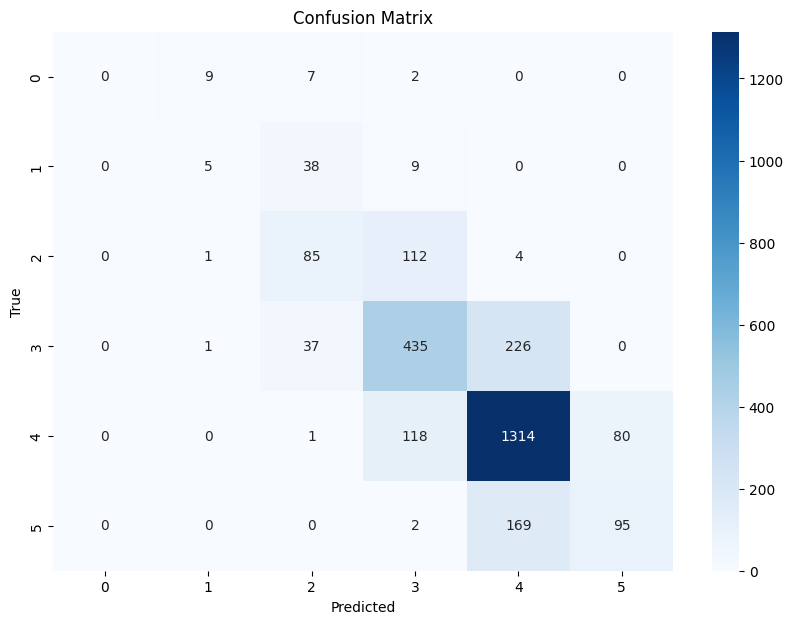

In [ ]:
df['Goal_Discretized'] = df['Goal'].apply(discretize_goal)

# Selecionar as variáveis de interesse
var_to_keep = ['ClimbRate', 'Sgz', 'P', 'Q', 'CurPitch', 'CurRoll', 'AbsRoll', 'DiffClb', 'DiffRollRate', 'DiffDiffClb',
               'DiffSeTime1', 'DiffSeTime3', 'DiffSeTime5', 'DiffSeTime7', 'DiffSeTime9', 'DiffSeTime11', 'DiffSeTime13',
               'Alpha', 'Se', 'Goal_Discretized']
df_filtered = df[var_to_keep]

# Definir variáveis independentes (X) e variável dependente (y)
X = df_filtered.drop('Goal_Discretized', axis=1)
y = df_filtered['Goal_Discretized']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Espaço de Hiperparâmetros
max_depth_values = [3, 5, 7, 10]

# Armazenar os resultados para cada configuração
results = []

for max_depth in max_depth_values:
    # Criar e treinar o modelo de Árvore de Decisão
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Fazer previsões
    y_pred = model.predict(X_test)

    # Avaliar o modelo
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    results.append({
        'max_depth': max_depth,
        'Confusion Matrix': conf_matrix,
        'Classification Report': class_report
    })

    print(f"Resultados para max_depth={max_depth}:")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

# Opcional: Visualizar a matriz de confusão para um dos modelos
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Exemplo de visualização para o max_depth=5
plot_confusion_matrix(results[1]['Confusion Matrix'], labels=list(range(6)))

 - ### K-NN
     - Espaço Hiperparâmetro: max_depth: {X, Y}

In [ ]:
# Discretização da variável 'Goal'
def discretize_goal(value):
    for class_label, (lower, upper) in classes.items():
        if lower < value <= upper:
            return class_label

classes = {0.0: (-np.inf, -0.0025),
           1.0: (-0.0025, -0.0020),
           2.0: (-0.0020, -0.0015),
           3.0: (-0.0015, -0.0010),
           4.0: (-0.0010, -0.0005),
           5.0: (-0.0005, np.inf)}

# Aplicar a discretização
df['Goal_discrete'] = df['Goal'].apply(discretize_goal)

# Definir variáveis independentes (X) e variável dependente (y)
var_to_keep = ['ClimbRate', 'Sgz', 'P', 'Q', 'CurPitch', 'CurRoll', 'AbsRoll', 'DiffClb', 'DiffRollRate', 'DiffDiffClb',
               'DiffSeTime1', 'DiffSeTime3', 'DiffSeTime5', 'DiffSeTime7', 'DiffSeTime9', 'DiffSeTime11', 'DiffSeTime13',
               'Alpha', 'Se']
X = df[var_to_keep]
y = df['Goal_discrete']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hiperparâmetros para K-NN
n_neighbors_values = [3, 5, 7]  # Defina W e Z aqui

# Armazenar resultados
knn_results = []

for n_neighbors in n_neighbors_values:
    # Criar o modelo K-NN com o número especificado de vizinhos
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)

    # Fazer previsões
    y_pred = knn_model.predict(X_test)

    # Avaliar o modelo
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    knn_results.append({
        'n_neighbors': n_neighbors,
        'Accuracy': accuracy,
        'Classification Report': report
    })

# Criar DataFrame para resultados
knn_results_df = pd.DataFrame(knn_results)
print(knn_results_df)

def discretize_goal(value):
    for k, (low, high) in classes.items():
        if low < value <= high:
            return k
    return None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   n_neighbors  Accuracy                              Classification Report
0            3  0.486909  {'0.0': {'precision': 0.0, 'recall': 0.0, 'f1-...
1            5  0.539273  {'0.0': {'precision': 0.3333333333333333, 'rec...
2            7  0.555636  {'0.0': {'precision': 0.0, 'recall': 0.0, 'f1-...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 - ### XGBoost
     - Espaço Hiperparâmetro: instrucoes.txt

In [ ]:

var_to_keep = ['ClimbRate', 'Sgz', 'P', 'Q', 'CurPitch', 'CurRoll', 'AbsRoll', 'DiffClb', 'DiffRollRate', 'DiffDiffClb',
               'DiffSeTime1', 'DiffSeTime3', 'DiffSeTime5', 'DiffSeTime7', 'DiffSeTime9', 'DiffSeTime11', 'DiffSeTime13', 'Alpha', 'Se', 'Goal']
df_filtered = df[var_to_keep]

# Discretizar a variável Goal
classes = {0.0: (-np.inf, -0.0025),
           1.0: (-0.0025, -0.0020),
           2.0: (-0.0020, -0.0015),
           3.0: (-0.0015, -0.0010),
           4.0: (-0.0010, -0.0005),
           5.0: (-0.0005, np.inf)}

def discretize_goal(value):
    for key, (low, high) in classes.items():
        if low < value <= high:
            return key
    return np.nan

df_filtered['GoalClass'] = df_filtered['Goal'].apply(discretize_goal)

# Remover a coluna original Goal
X = df_filtered.drop(['Goal', 'GoalClass'], axis=1)
y = df_filtered['GoalClass']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Lista de combinações de hiperparâmetros
params = [
    [50, 4, 0.2],
    [50, 10, 1],
    [50, 10, 0.2],
    [50, 10, 0.04],
    [200, 4, 1],
    [200, 4, 0.2],
    [200, 4, 0.04],
    [200, 10, 0.2]
]

# Armazenar os resultados para cada combinação de hiperparâmetros
xgboost_results = []

for param in params:
    n_estimators, max_depth, learning_rate = param

    # Criar o modelo XGBoost com os parâmetros especificados
    xgb_model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, objective='multi:softprob', num_class=len(classes))
    xgb_model.fit(X_train, y_train)

    # Fazer previsões
    y_pred = xgb_model.predict(X_test)

    # Avaliar o modelo
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    xgboost_results.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'Accuracy': accuracy,
        'Confusion Matrix': confusion,
        'Classification Report': report
    })

# Exibir os resultados
for result in xgboost_results:
    print(f"n_estimators: {result['n_estimators']}, max_depth: {result['max_depth']}, learning_rate: {result['learning_rate']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print("Confusion Matrix:")
    print(result['Confusion Matrix'])
    print("Classification Report:")
    print(result['Classification Report'])
    print("\n")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-52-a8ead928facf>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['GoalClass'] = df_filtered['Goal'].apply(discretize_goal)


n_estimators: 50, max_depth: 4, learning_rate: 0.2
Accuracy: 0.7502
Confusion Matrix:
[[   4    5    3    0    0    0]
 [   3    7   34    3    0    0]
 [   0   10   96   86    1    0]
 [   0    1   36  467  185    0]
 [   0    0    4  128 1370   41]
 [   0    0    0    1  146  119]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.33      0.42        12
         1.0       0.30      0.15      0.20        47
         2.0       0.55      0.50      0.52       193
         3.0       0.68      0.68      0.68       689
         4.0       0.80      0.89      0.84      1543
         5.0       0.74      0.45      0.56       266

    accuracy                           0.75      2750
   macro avg       0.61      0.50      0.54      2750
weighted avg       0.74      0.75      0.74      2750



n_estimators: 50, max_depth: 10, learning_rate: 1
Accuracy: 0.7433
Confusion Matrix:
[[   2    8    2    0    0    0]
 [   2   16   26    3    0   

## 2. Do modelo de Regressão Logística compare os odds-ratio do coeficiente independente para cada classe. Escolha 2 atributos e compare o odds-ratiopara as diferentes classes.

Para comparar os odds-ratio dos coeficientes independentes para cada classe em um modelo de Regressão Logística, primeiro treinaremos o modelo de Regressão Logística multinomial. Em seguida, extrair os coeficientes do modelo e calcular os odds-ratios para cada classe. Por fim, compararemos os odds-ratios para dois atributos selecionados.

In [ ]:
def discretize_goal(value):
    for key, (lower, upper) in classes.items():
        if lower < value <= upper:
            return key
    return np.nan

df_filtered['GoalClass'] = df_filtered['Goal'].apply(discretize_goal)

# Remover registros com valor NaN (se houver)
df_filtered.dropna(subset=['GoalClass'], inplace=True)

# Definir variáveis independentes (X) e variável dependente (y)
X = df_filtered.drop(['Goal', 'GoalClass'], axis=1)
y = df_filtered['GoalClass']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo de Regressão Logística Multinomial
logistic_model = LogisticRegression(max_iter=1000, multi_class='multinomial')
logistic_model.fit(X_train, y_train)

# Extrair os coeficientes do modelo
coefficients = logistic_model.coef_

# Calcular os odds-ratio
odds_ratios = np.exp(coefficients)

# Criar DataFrame para visualização
classes = logistic_model.classes_
attributes = X.columns

odds_ratio_df = pd.DataFrame(odds_ratios, columns=attributes, index=classes)
print(odds_ratio_df)

# Selecionar 2 atributos para comparar os odds-ratio
selected_attributes = ['ClimbRate', 'P']
odds_ratio_selected = odds_ratio_df[selected_attributes]
print(odds_ratio_selected)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-53-35b80321ea82>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['GoalClass'] = df_filtered['Goal'].apply(discretize_goal)
<ipython-input-53-35b80321ea82>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

     ClimbRate       Sgz         P         Q  CurPitch   CurRoll   AbsRoll  \
0.0   1.000249  0.987944  1.237644  1.140306  1.001416  0.821453  1.101692   
1.0   1.000466  0.990467  1.853112  1.407866  1.371957  1.206045  0.902386   
2.0   1.000657  1.003677  6.133259  1.829111  1.431983  1.742856  0.683682   
3.0   1.000487  1.002673  5.886531  0.894140  1.197605  1.580015  0.764594   
4.0   0.998585  1.006645  0.462547  0.505365  0.178644  0.908514  1.066860   
5.0   0.999558  1.008784  0.026109  0.753644  2.375778  0.403459  1.803662   

      DiffClb  DiffRollRate  DiffDiffClb  DiffSeTime1  DiffSeTime3  \
0.0  1.042652      1.005852     0.908811     1.000039     1.000134   
1.0  0.960191      0.996318     1.035605     1.000087     1.000182   
2.0  0.999609      0.992857     0.913794     1.000222     1.000238   
3.0  0.989117      1.003973     0.985183     1.002146     0.999961   
4.0  0.978335      1.000015     1.025417     1.000668     1.001045   
5.0  1.032613      1.001043     1

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Interpretação dos Resultados
#### Odds-Ratio

  - Odds-ratio: Indica a multiplicação dos odds de uma classe em comparação com a classe base para uma unidade de aumento no atributo.
  - Coeficientes Positivos: Um coeficiente positivo indica que, à medida que o valor do atributo aumenta, a probabilidade da classe aumenta em comparação com a classe base.
  - Coeficientes Negativos: Um coeficiente negativo indica que, à medida que o valor do atributo aumenta, a probabilidade da classe diminui em comparação com a classe base.

#### Comparação dos Atributos Selecionados

  - ClimbRate: Comparar como o aumento na taxa de subida afeta as odds para cada classe em relação à classe base.
  - P (Taxa de rotação): Comparar como o aumento na taxa de rotação afeta as odds para cada classe em relação à classe base.

### Análise

Os resultados do DataFrame odds_ratio_df e odds_ratio_selected mostram os odds-ratios para cada atributo e classe. Ao comparar os odds-ratios para ClimbRate e P, podemos observar quais classes são mais influenciadas por esses atributos e como as odds mudam para diferentes valores desses atributos.

### Observações

  - Significância dos Atributos: Nem todos os atributos terão um impacto significativo em todas as classes. O valor do odds-ratio próximo de 1 indica que o atributo tem pouco ou nenhum efeito na probabilidade da classe.
  - Contexto de Aplicação: Em aplicações práticas, a interpretação dos odds-ratios deve considerar o contexto operacional e a importância relativa dos atributos para a segurança e conforto do voo.

Este método fornece uma análise detalhada dos efeitos dos atributos selecionados nas probabilidades de classificação das diferentes classes, ajudando a entender melhor os fatores que influenciam a deflexão dos ailerons.

## 3. Qual a suposição utilizada que dá o nome "Naive" no modelo de Naive Bayes?

 - **Resposta**: A suposição que dá o nome "Naive" ao modelo de Naive Bayes é a independência condicional. Especificamente, o modelo assume que todos os atributos (ou características) de entrada são mutuamente independentes, dados a classe.

  #### Detalhamento da Suposição de Independência Condicional

   - Independência Condicional: Naive Bayes assume que a presença (ou ausência) de uma determinada característica de uma classe não está relacionada com a presença (ou ausência) de qualquer outra característica. Isto significa que, para calcular a probabilidade de uma amostra pertencer a uma determinada classe, o modelo considera cada atributo de forma independente.

   - Fórmula Matemática: Se X=(X1,X2,…,Xn)X=(X1​,X2​,…,Xn​) são os atributos e YY é a classe, o modelo de Naive Bayes calcula a probabilidade P(Y∣X)P(Y∣X) como:

        P(Y∣X)∝P(Y)∏i=1nP(Xi∣Y)P(Y∣X)∝P(Y)∏i=1n​P(Xi​∣Y)

        Aqui, P(Y)é a probabilidade a priori da classe YY, e P(Xi∣Y)P(Xi​∣Y) é a probabilidade condicional de cada atributo XiXi​ dado a classe YY.

  #### Porque essa Suposição é "Ingênua"

   - Realismo: Na prática, os atributos de um problema real muitas vezes não são completamente independentes. Por exemplo, em um problema de diagnóstico médico, os sintomas de uma doença podem estar correlacionados entre si.
   - Simplicidade: Apesar da suposição ser frequentemente irrealista, ela simplifica significativamente os cálculos e a implementação do modelo, tornando o Naive Bayes computacionalmente eficiente e fácil de interpretar.
   - Desempenho Surpreendente: Curiosamente, mesmo com a suposição de independência, o modelo Naive Bayes frequentemente proporciona bons resultados na prática, especialmente em contextos de classificação de texto e sistemas de recomendação.

  #### Exemplos de Aplicação

   - Classificação de Texto: Em classificação de e-mails como spam ou não spam, as palavras são tratadas como independentes umas das outras.
   - Sistemas de Recomendação: Naive Bayes pode ser utilizado para recomendar produtos com base em atributos tratados de forma independente, como categorias e avaliações.

  #### Conclusão

  A suposição de independência condicional é a base do "naive" no Naive Bayes. Embora esta suposição seja frequentemente violada em problemas do mundo real, a simplicidade do modelo e sua capacidade de fornecer boas previsões em muitos casos práticos justificam seu uso contínuo e sua popularidade em diversas aplicações de aprendizado de máquina.


## 4. Observando o Teorema de Bayes no contexto de Naive Bayes, uma parcela é uma constante de normalização e pode ser desconsiderada a menos de proporcionalidade. Outra parcela é um produto de probabilidades e então é aplicado o logaritmo no processo para evitar erros por underflow. Reescreva o Teorema de Bayes com essas considerações.

 - **Resposta**: No contexto do modelo Naive Bayes, o Teorema de Bayes é ajustado para aproveitar a suposição de independência condicional dos atributos e lidar com problemas de computação, como o underflow. Aqui estão os passos para reescrever o Teorema de Bayes com essas considerações:
   - **Teorema de Bayes**

        O Teorema de Bayes pode ser expresso como:

        P(Y∣X)=P(X∣Y)⋅P(Y)P(X)P(Y∣X)=P(X)P(X∣Y)⋅P(Y)​

        onde:

       - P(Y∣X)P(Y∣X) é a probabilidade posterior da classe YY dado o vetor de atributos XX.
       - P(X∣Y)P(X∣Y) é a probabilidade condicional dos atributos XX dado a classe YY.
       - P(Y)P(Y) é a probabilidade a priori da classe YY.
       - P(X)P(X) é a probabilidade marginal dos atributos XX.

   - **Ajuste para o Modelo Naive Bayes**

      1. Supressão da Constante de Normalização: A constante P(X)P(X) não é dependente da classe YY e não afeta a comparação entre diferentes classes. Assim, no contexto de classificação, podemos desprezar P(X)P(X) e focar na parte proporcional:

      P(Y∣X)∝P(X∣Y)⋅P(Y)P(Y∣X)∝P(X∣Y)⋅P(Y)

      2. Produto de Probabilidades e Logaritmo: Para evitar problemas de underflow quando se trabalha com produtos de probabilidades pequenas, aplicamos o logaritmo. A função logarítmica transforma o produto de probabilidades em uma soma de logaritmos:

      log⁡P(Y∣X)∝log⁡P(X∣Y)+log⁡P(Y)logP(Y∣X)∝logP(X∣Y)+logP(Y)

   - **Independência Condicional**

      Com a suposição de independência condicional, a probabilidade condicional P(X∣Y)P(X∣Y) é decomposta como um produto das probabilidades de cada atributo dado a classe:

      P(X∣Y)=∏i=1nP(Xi∣Y)P(X∣Y)=∏i=1n​P(Xi​∣Y)

      Portanto, o logaritmo da probabilidade condicional é:

      log⁡P(X∣Y)=∑i=1nlog⁡P(Xi∣Y)logP(X∣Y)=∑i=1n​logP(Xi​∣Y)

   - **Fórmula Final**

      Incorporando todas essas considerações, o logaritmo da probabilidade posterior P(Y∣X)P(Y∣X) é:

      log⁡P(Y∣X)∝∑i=1nlog⁡P(Xi∣Y)+log⁡P(Y)logP(Y∣X)∝∑i=1n​logP(Xi​∣Y)+logP(Y)

      Finalmente, para a classificação, escolhemos a classe YY que maximiza a probabilidade posterior P(Y∣X)P(Y∣X). Em termos de logaritmos, isso equivale a maximizar:

      log⁡P(Y∣X)=∑i=1nlog⁡P(Xi∣Y)+log⁡P(Y)logP(Y∣X)=∑i=1n​logP(Xi​∣Y)+logP(Y)

   - **Conclusão**

      Este ajuste ao Teorema de Bayes para o modelo Naive Bayes, com a exclusão da constante de normalização e a aplicação do logaritmo, facilita o cálculo e evita problemas de underflow, além de manter a abordagem baseada na proporcionalidade das probabilidades.

## 5. Para este conjunto de dados a suposição gaussiana é razoável?

Para determinar se a suposição gaussiana é razoável para um conjunto de dados, precisamos avaliar se as variáveis seguem uma distribuição aproximadamente normal. No contexto de modelos de Naive Bayes, a suposição gaussiana se refere ao Naive Bayes Gaussiano, que assume que as características contínuas seguem uma distribuição normal (gaussiana) condicionada à classe.

 - ### Passos para Avaliar a Suposição Gaussiana

    1. Visualização dos Dados: Plotar histogramas e gráficos de densidade para as variáveis contínuas e verificar visualmente se se aproximam de uma distribuição normal.
    2. Testes Estatísticos: Aplicar testes estatísticos para verificar a normalidade das variáveis. Testes comuns incluem o teste de Shapiro-Wilk e o teste de Kolmogorov-Smirnov.
    3. Q-Q Plots: Utilizar gráficos quantil-quantil (Q-Q plots) para comparar a distribuição dos dados com uma distribuição normal.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


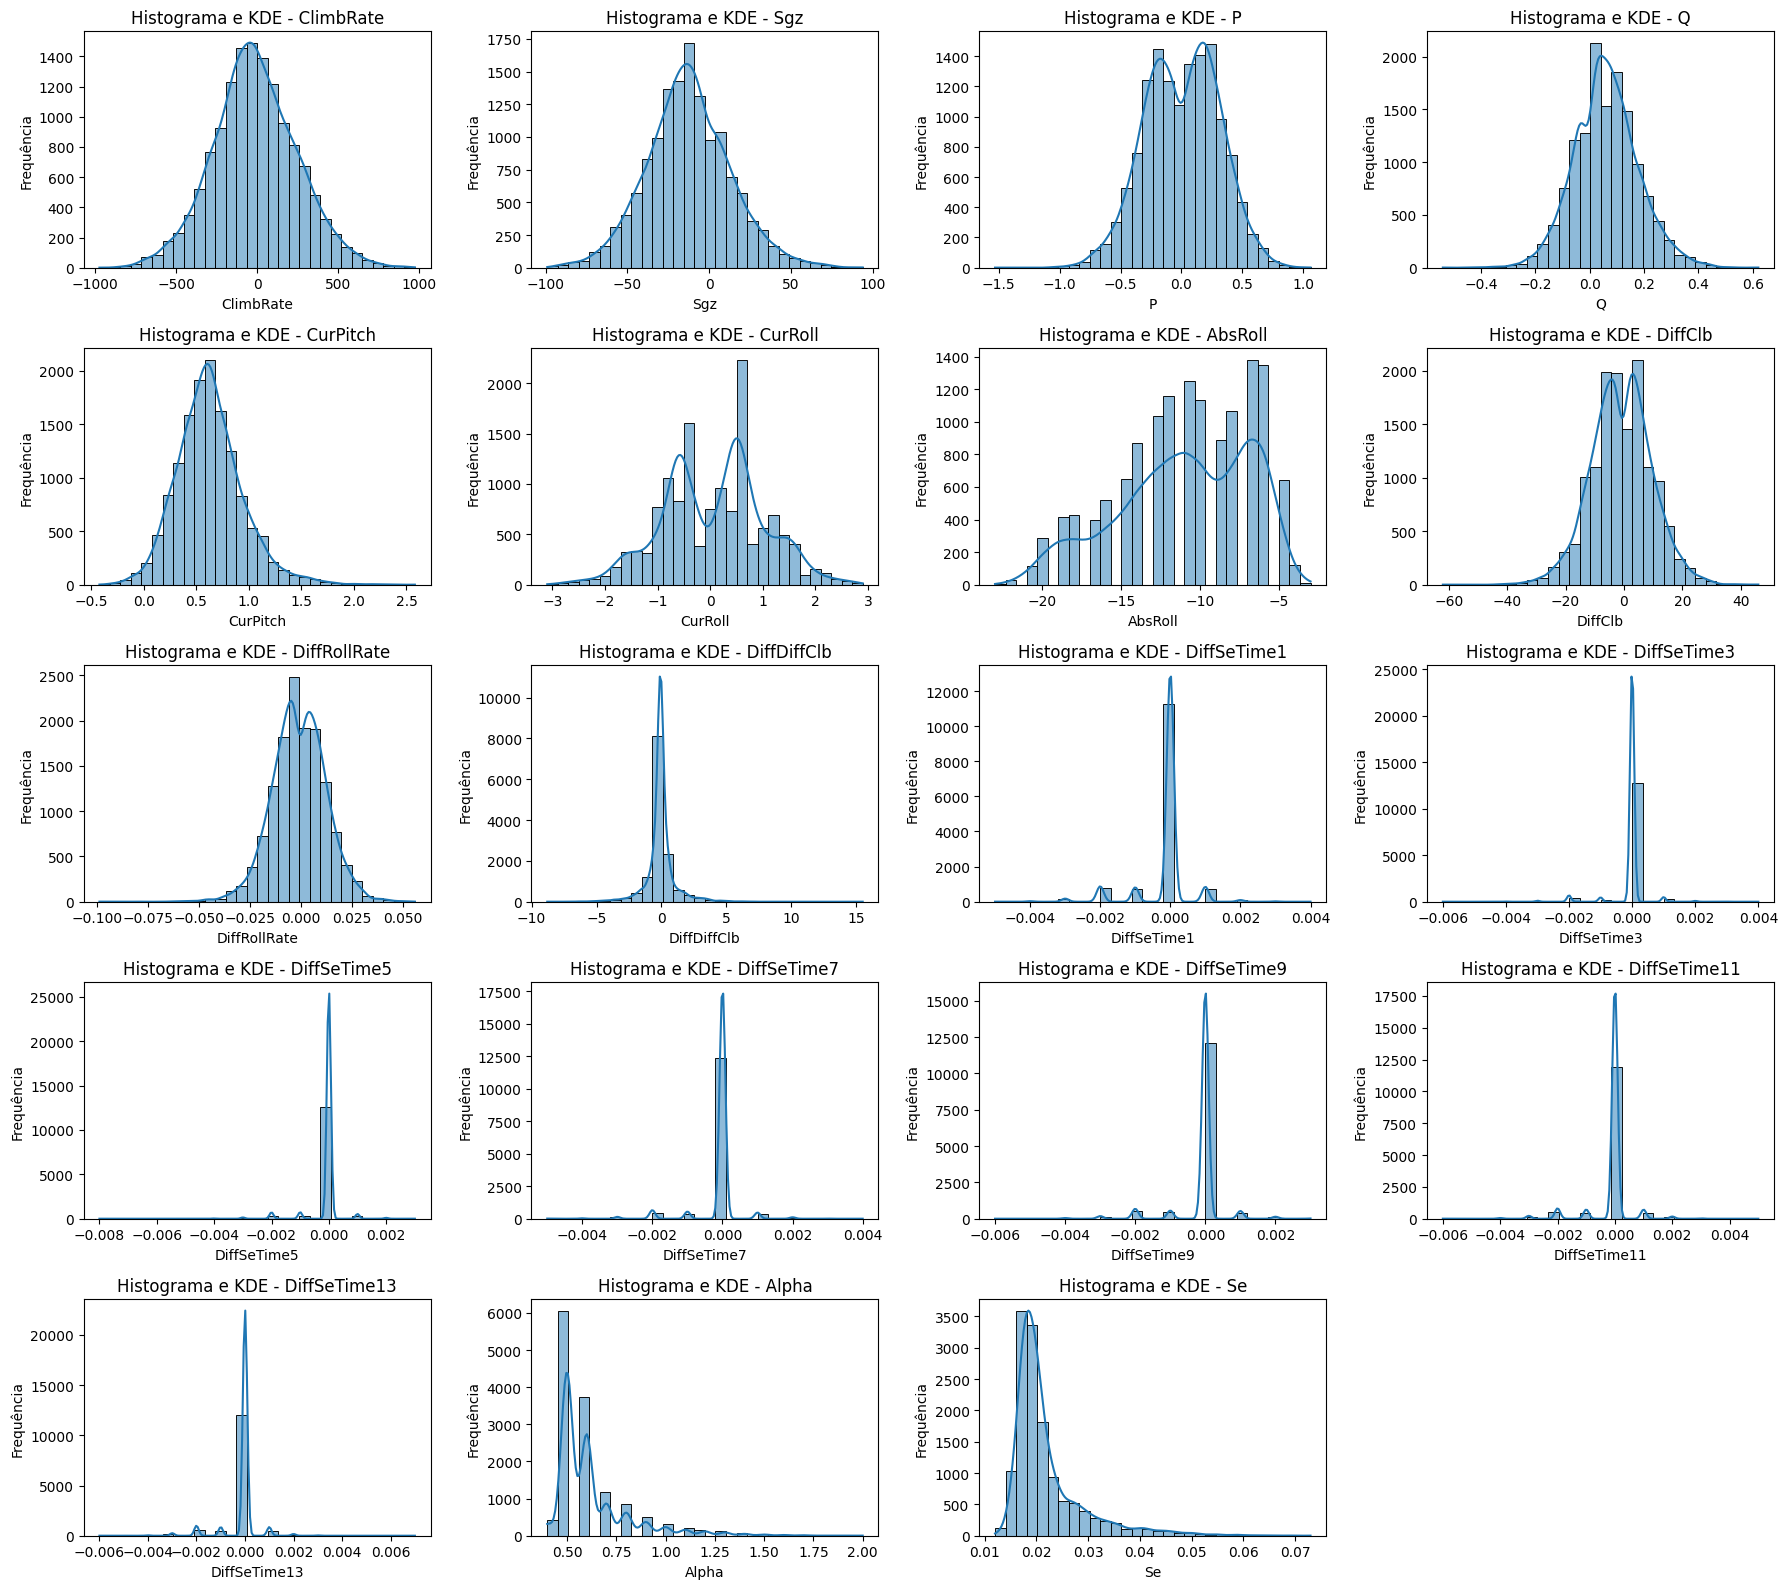

Testes de Normalidade:
ClimbRate: Estatística=0.998, p-valor=0.000
Sgz: Estatística=0.996, p-valor=0.000
P: Estatística=0.996, p-valor=0.000
Q: Estatística=0.995, p-valor=0.000
CurPitch: Estatística=0.980, p-valor=0.000
CurRoll: Estatística=0.993, p-valor=0.000
AbsRoll: Estatística=0.960, p-valor=0.000
DiffClb: Estatística=0.997, p-valor=0.000
DiffRollRate: Estatística=0.994, p-valor=0.000
DiffDiffClb: Estatística=0.806, p-valor=0.000
DiffSeTime1: Estatística=0.560, p-valor=0.000
DiffSeTime3: Estatística=0.309, p-valor=0.000
DiffSeTime5: Estatística=0.335, p-valor=0.000
DiffSeTime7: Estatística=0.391, p-valor=0.000
DiffSeTime9: Estatística=0.441, p-valor=0.000
DiffSeTime11: Estatística=0.463, p-valor=0.000
DiffSeTime13: Estatística=0.451, p-valor=0.000
Alpha: Estatística=0.718, p-valor=0.000
Se: Estatística=0.754, p-valor=0.000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 13750.
  res = hypotest_fun_out(*samples, **kwds)


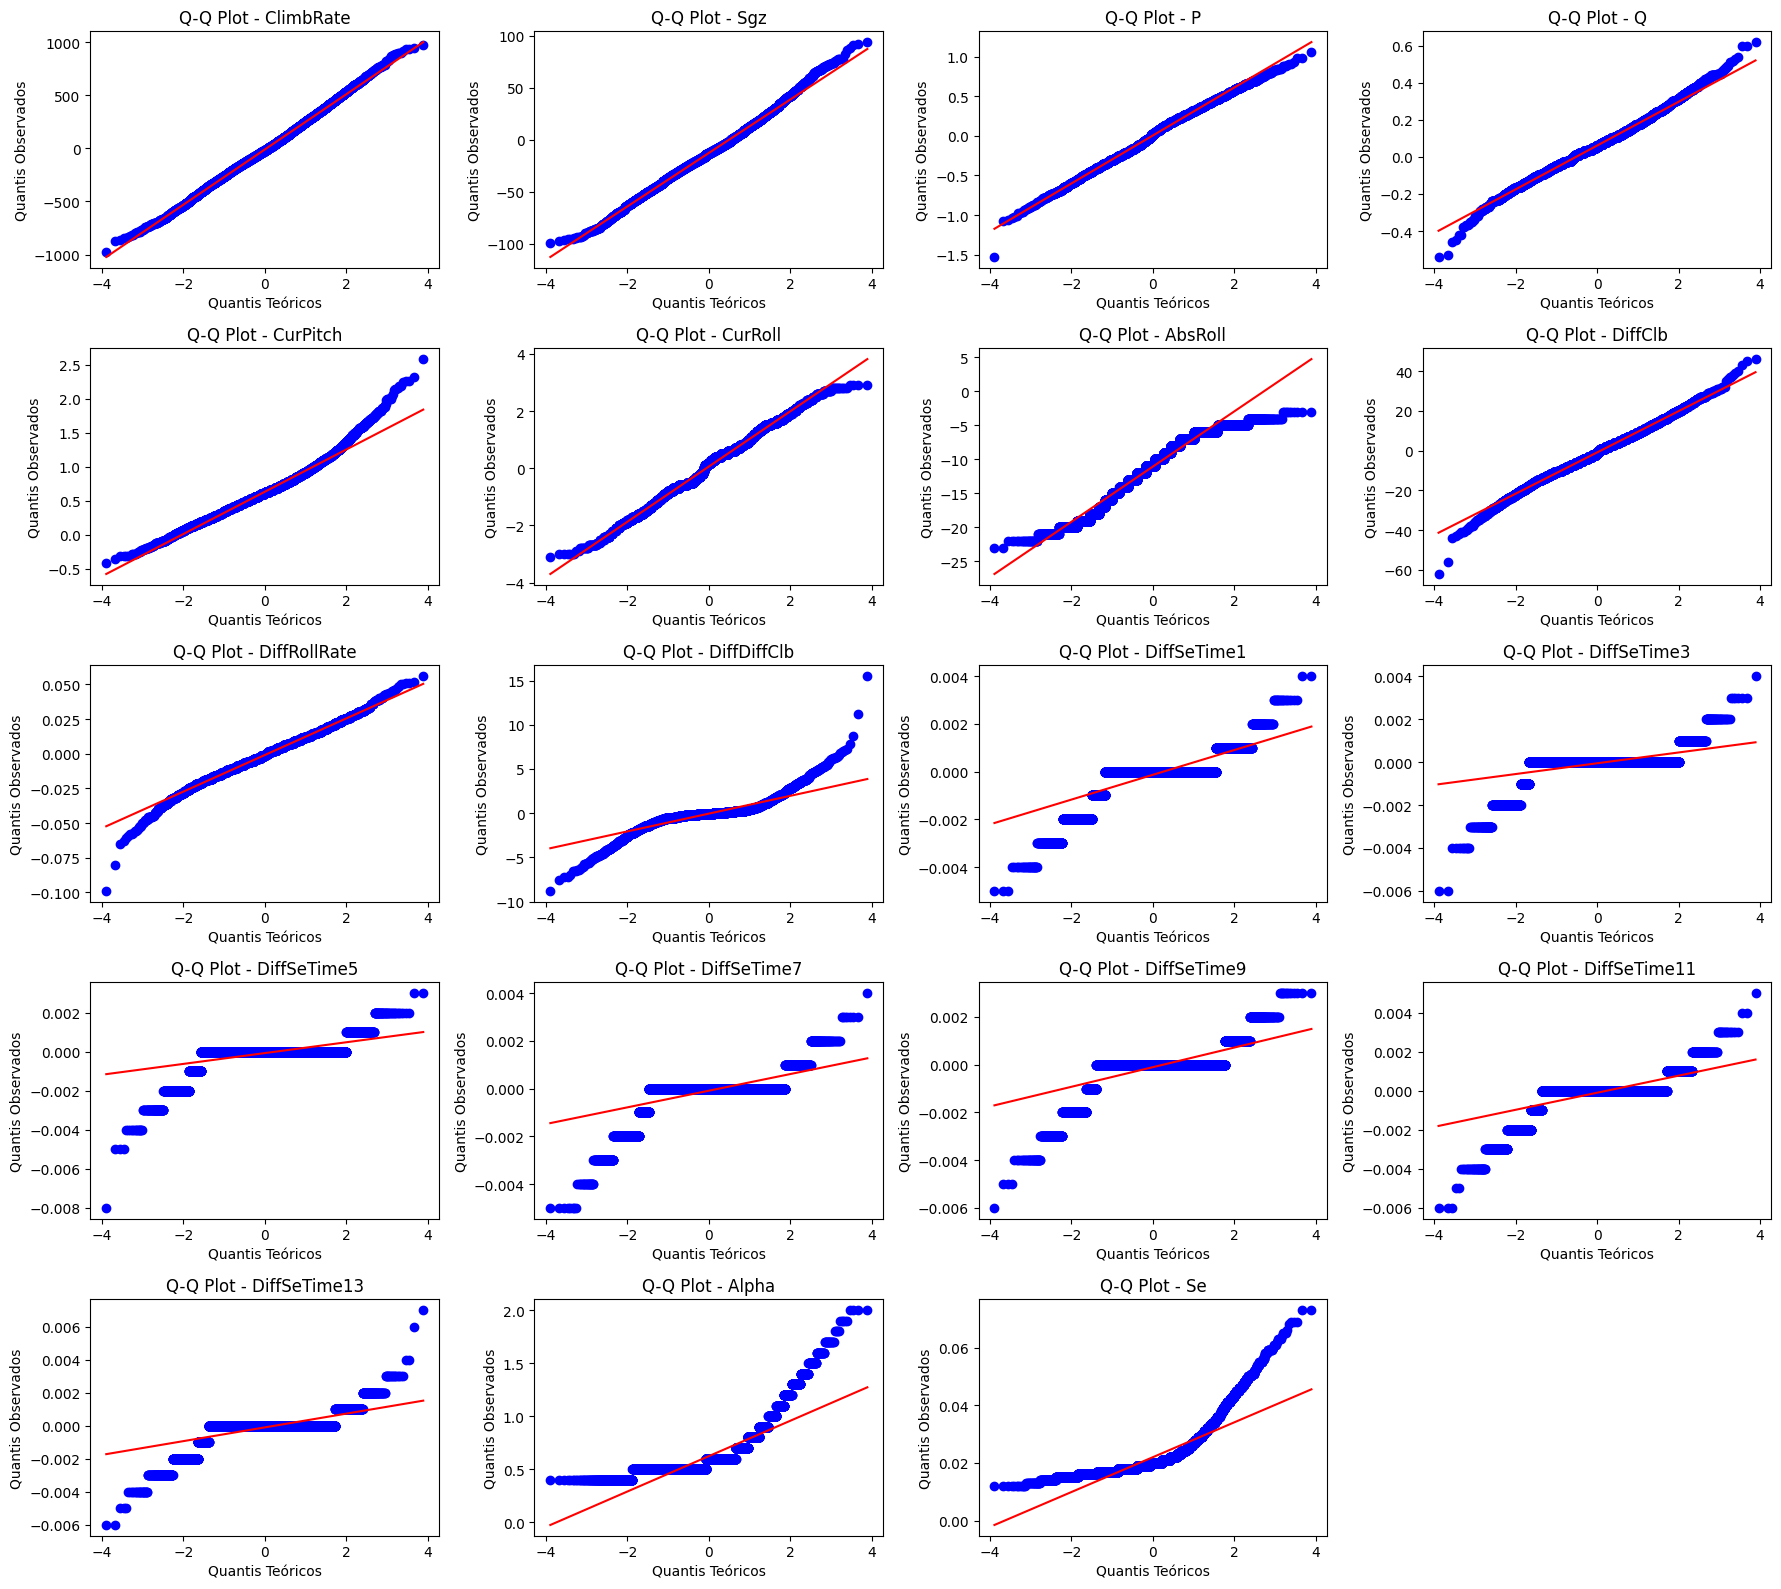

In [ ]:
var_continuas = ['ClimbRate', 'Sgz', 'P', 'Q', 'CurPitch', 'CurRoll', 'AbsRoll',
                 'DiffClb', 'DiffRollRate', 'DiffDiffClb', 'DiffSeTime1',
                 'DiffSeTime3', 'DiffSeTime5', 'DiffSeTime7', 'DiffSeTime9',
                 'DiffSeTime11', 'DiffSeTime13', 'Alpha', 'Se']

# Plotar histogramas e gráficos de densidade
plt.figure(figsize=(18, 16))
for i, var in enumerate(var_continuas, 1):
    plt.subplot(5, 4, i)
    sns.histplot(df[var], kde=True, bins=30)
    plt.title(f'Histograma e KDE - {var}')
    plt.xlabel(var)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

# Aplicar testes de normalidade
print("Testes de Normalidade:")
for var in var_continuas:
    stat, p_value = stats.shapiro(df[var].dropna())
    print(f"{var}: Estatística={stat:.3f}, p-valor={p_value:.3f}")

# Plotar Q-Q plots
plt.figure(figsize=(18, 16))
for i, var in enumerate(var_continuas, 1):
    plt.subplot(5, 4, i)
    stats.probplot(df[var].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot - {var}')
    plt.xlabel('Quantis Teóricos')
    plt.ylabel('Quantis Observados')

plt.tight_layout()
plt.show()

## 6. No modelo de Árvores de Decisão: Qual o melhor hiperparâmetro X para generalização? Qual o melhor hiperparâmetro Y para minimizar o erro empírico? Para uma predição em um novo dado qual dos dois modelos deve ser escolhido?

 - **Resposta**:
    
      No contexto de modelos de Árvores de Decisão, escolher o melhor hiperparâmetro para generalização e para minimizar o erro empírico envolve diferentes aspectos de ajuste e avaliação. Aqui está uma explicação detalhada sobre como abordar essas escolhas:

      1. #### Hiperparâmetro para Generalização

        - Hiperparâmetro X: max_depth

          1. O que é: max_depth define a profundidade máxima da árvore de decisão. Limitar a profundidade ajuda a evitar o sobreajuste (overfitting) ao controlar a complexidade do modelo.
          2. Objetivo: Encontrar a profundidade que maximiza a capacidade do modelo de generalizar para novos dados sem se ajustar excessivamente aos dados de treinamento.
          3. Como escolher: Realize uma busca por validação cruzada para diferentes profundidades e escolha aquela que apresenta o melhor desempenho em dados de validação. Profundidades muito baixas podem subajustar o modelo (underfitting), enquanto profundidades muito altas podem levar ao sobreajuste.

      2. #### Hiperparâmetro para Minimizar o Erro Empírico

        - Hiperparâmetro Y: min_samples_split ou min_samples_leaf

           - O que são:
             - min_samples_split: O número mínimo de amostras necessárias para dividir um nó interno. Menores valores permitem divisões mais finas e detalhadas, enquanto valores maiores resultam em divisões mais gerais.
             - min_samples_leaf: O número mínimo de amostras que deve estar presente em um nó folha. Controla a profundidade da árvore e evita folhas com poucas amostras, ajudando a evitar sobreajuste.
          - Objetivo: Minimizar o erro empírico, que é o erro calculado no conjunto de treinamento. Ajustar esses hiperparâmetros pode ajudar a modelar os dados mais detalhadamente, reduzindo o erro empírico.
          - Como escolher: Use uma busca por validação cruzada para testar diferentes valores desses hiperparâmetros e escolha aqueles que minimizam o erro empírico.

      3. #### Comparação dos Modelos

       - Modelo que Maximiza a Generalização: Focado em encontrar o melhor max_depth para evitar o sobreajuste e garantir que o modelo se generalize bem para novos dados. Esse modelo geralmente terá melhor desempenho em um conjunto de validação ou teste, indicando que foi bem ajustado para não se sobreajustar aos dados de treinamento.

       - Modelo que Minimiza o Erro Empírico: Focado em encontrar o melhor min_samples_split ou min_samples_leaf para minimizar o erro nos dados de treinamento. Esse modelo pode ter um desempenho muito bom no conjunto de treinamento, mas pode não se generalizar bem para novos dados se for muito específico.

      4. #### Escolha do Modelo para Predição em Novo Dado

       - Modelo de Generalização: Para predição em novos dados, o modelo que melhor generaliza (ou seja, o que tem o melhor max_depth encontrado por validação cruzada) geralmente é a melhor escolha. Esse modelo tem uma maior probabilidade de manter um bom desempenho em dados não vistos, ao contrário do modelo ajustado apenas para minimizar o erro empírico, que pode ter problemas de sobreajuste.

       - Modelo com Erro Empírico Minimizado: Embora esse modelo possa ter um desempenho superior nos dados de treinamento, ele pode não ser o ideal para novos dados, pois pode ter se ajustado muito aos dados específicos de treinamento e não generalizar bem.

      5. #### Conclusão

      Para predição em novos dados, o modelo com o melhor hiperparâmetro max_depth para generalização deve ser escolhido. Este modelo é mais robusto e menos suscetível a sobreajuste, oferecendo uma melhor performance em dados não vistos. O modelo que minimiza o erro empírico pode ser útil para análises de treinamento, mas não é necessariamente o melhor para generalização a novos dados.


## 7. No modelo K-NN: Qual o melhor hiperparâmetro W para generalização? Qual o melhor hiperparâmetro Z para minimizar o erro empírico?

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

# Carregar o dataset
path = "/content/ailerons.csv"
df = pd.read_csv(path)

# Selecionar as variáveis de interesse
var_to_keep = ['ClimbRate', 'Sgz', 'P', 'Q', 'CurPitch', 'CurRoll', 'AbsRoll', 'DiffClb', 'DiffRollRate', 'DiffDiffClb',
               'DiffSeTime1', 'DiffSeTime3', 'DiffSeTime5', 'DiffSeTime7', 'DiffSeTime9', 'DiffSeTime11', 'DiffSeTime13',
               'Alpha', 'Se', 'Goal']
df_filtered = df[var_to_keep]

# Discretizar a variável Goal conforme as classes fornecidas
classes = {0.0: (-np.inf, -0.0025),
           1.0: (-0.0025, -0.0020),
           2.0: (-0.0020, -0.0015),
           3.0: (-0.0015, -0.0010),
           4.0: (-0.0010, -0.0005),
           5.0: (-0.0005, np.inf)}

def discretize_goal(value):
    for key, (low, high) in classes.items():
        if low < value <= high:
            return key
    return np.nan

df_filtered['Goal'] = df_filtered['Goal'].apply(discretize_goal)

# Remover linhas com valores NaN (caso existam)
df_filtered.dropna(subset=['Goal'], inplace=True)

# Definir variáveis independentes (X) e variável dependente (y)
X = df_filtered.drop('Goal', axis=1)
y = df_filtered['Goal']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hiperparâmetros a testar
n_neighbors_list = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

# Armazenar os resultados para cada valor de n_neighbors
results = []

for n_neighbors in n_neighbors_list:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)

    # Previsões no conjunto de teste
    y_pred_test = knn_model.predict(X_test)

    # Previsões no conjunto de treinamento (para avaliar erro empírico)
    y_pred_train = knn_model.predict(X_train)

    # Avaliar o modelo
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')
    train_f1 = f1_score(y_train, y_pred_train, average='weighted')

    results.append({
        'n_neighbors': n_neighbors,
        'Test Accuracy': test_accuracy,
        'Train Accuracy': train_accuracy,
        'Test F1 Score': test_f1,
        'Train F1 Score': train_f1
    })

# Criar um DataFrame para exibir os resultados
results_df = pd.DataFrame(results)

# Identificar os melhores hiperparâmetros
best_generalization = results_df.loc[results_df['Test Accuracy'].idxmax()]['n_neighbors']
best_empirical = results_df.loc[results_df['Train Accuracy'].idxmax()]['n_neighbors']

print("Resultados K-NN:")
print(results_df)
print(f"\nMelhor hiperparâmetro W para generalização: {best_generalization}")
print(f"Melhor hiperparâmetro Z para minimizar o erro empírico: {best_empirical}")



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-55-c66623631d14>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Goal'] = df_filtered['Goal'].apply(discretize_goal)
<ipython-input-55-c66623631d14>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

Resultados K-NN:
    n_neighbors  Test Accuracy  Train Accuracy  Test F1 Score  Train F1 Score
0             3       0.486909        0.726636       0.470289        0.717733
1             5       0.539273        0.677273       0.496927        0.645555
2             7       0.555636        0.656091       0.499917        0.611494
3             9       0.557455        0.647636       0.490435        0.592399
4            11       0.564727        0.635727       0.488036        0.570387
5            13       0.567273        0.626273       0.483198        0.553215
6            15       0.564727        0.619364       0.475725        0.541328
7            17       0.568364        0.612273       0.472961        0.528680
8            19       0.567636        0.607182       0.466246        0.518355
9            21       0.564364        0.607364       0.460779        0.513914
10           23       0.568000        0.603182       0.460922        0.506493
11           25       0.568364        0.599818 

## 8. Compare o efeito dos hiperparâmetros do XGBoost e seus resultados

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier

# Carregar o dataset
path = "/content/ailerons.csv"
df = pd.read_csv(path)

# Selecionar as variáveis de interesse
var_to_keep = ['ClimbRate', 'Sgz', 'P', 'Q', 'CurPitch', 'CurRoll', 'AbsRoll', 'DiffClb', 'DiffRollRate', 'DiffDiffClb',
               'DiffSeTime1', 'DiffSeTime3', 'DiffSeTime5', 'DiffSeTime7', 'DiffSeTime9', 'DiffSeTime11', 'DiffSeTime13',
               'Alpha', 'Se', 'Goal']
df_filtered = df[var_to_keep]

# Definir a discretização das classes
classes = {0.0: (-np.inf, -0.0025),
           1.0: (-0.0025, -0.0020),
           2.0: (-0.0020, -0.0015),
           3.0: (-0.0015, -0.0010),
           4.0: (-0.0010, -0.0005),
           5.0: (-0.0005, np.inf)}

def discretize_goal(value):
    for k, v in classes.items():
        if v[0] < value <= v[1]:
            return k
    return None

df_filtered['GoalClass'] = df_filtered['Goal'].apply(discretize_goal)

# Definir variáveis independentes (X) e variável dependente (y)
X = df_filtered.drop(['Goal', 'GoalClass'], axis=1)
y = df_filtered['GoalClass']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Definir os hiperparâmetros para XGBoost
params = [
    [50, 4, 0.2],
    [50, 10, 1],
    [50, 10, 0.2],
    [50, 10, 0.04],
    [200, 4, 1],
    [200, 4, 0.2],
    [200, 4, 0.04],
    [200, 10, 0.2]
]

# Avaliar modelos XGBoost com diferentes hiperparâmetros
xgboost_results = []

for param in params:
    n_estimators, max_depth, learning_rate = param
    xgb_model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, objective='multi:softmax')
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_xgb)
    precision = precision_score(y_test, y_pred_xgb, average='weighted')
    recall = recall_score(y_test, y_pred_xgb, average='weighted')
    f1 = f1_score(y_test, y_pred_xgb, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred_xgb)

    xgboost_results.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': conf_matrix
    })

# Criar DataFrame para resultados do XGBoost
xgboost_results_df = pd.DataFrame(xgboost_results)

# Exibir resultados
print("\nResultados do XGBoost:")
print(xgboost_results_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-56-7eb049c697fc>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['GoalClass'] = df_filtered['Goal'].apply(discretize_goal)



Resultados do XGBoost:
   n_estimators  max_depth  learning_rate  Accuracy  Precision    Recall  \
0            50          4           0.20  0.750182   0.741033  0.750182   
1            50         10           1.00  0.743273   0.735919  0.743273   
2            50         10           0.20  0.758182   0.750804  0.758182   
3            50         10           0.04  0.748727   0.740375  0.748727   
4           200          4           1.00  0.732000   0.724881  0.732000   
5           200          4           0.20  0.763273   0.756408  0.763273   
6           200          4           0.04  0.748364   0.738808  0.748364   
7           200         10           0.20  0.758545   0.751984  0.758545   

   F1 Score                                   Confusion Matrix  
0  0.740197  [[4, 5, 3, 0, 0, 0], [3, 7, 34, 3, 0, 0], [0, ...  
1  0.737569  [[2, 8, 2, 0, 0, 0], [2, 16, 26, 3, 0, 0], [1,...  
2  0.750672  [[5, 5, 2, 0, 0, 0], [2, 12, 31, 2, 0, 0], [1,...  
3  0.740428  [[4, 4, 3, 0, 1, 0

## 9. Utilize métricas de avaliação e compare os diferentes modelos de classificação na predição da deflexão dos ailerons.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Carregar o dataset
path = "/content/ailerons.csv"
df = pd.read_csv(path)

# Selecionar as variáveis de interesse
var_to_keep = ['ClimbRate', 'Sgz', 'P', 'Q', 'CurPitch', 'CurRoll', 'AbsRoll', 'DiffClb', 'DiffRollRate', 'DiffDiffClb',
               'DiffSeTime1', 'DiffSeTime3', 'DiffSeTime5', 'DiffSeTime7', 'DiffSeTime9', 'DiffSeTime11', 'DiffSeTime13',
               'Alpha', 'Se', 'Goal']
df_filtered = df[var_to_keep]

# Discretização da variável 'Goal'
classes = {0.0: (-np.inf, -0.0025),
           1.0: (-0.0025, -0.0020),
           2.0: (-0.0020, -0.0015),
           3.0: (-0.0015, -0.0010),
           4.0: (-0.0010, -0.0005),
           5.0: (-0.0005, np.inf)}

def discretize_goal(value):
    for key, (low, high) in classes.items():
        if low < value <= high:
            return key
    return np.nan

df_filtered['Goal'] = df_filtered['Goal'].apply(discretize_goal)

# Remover linhas com valores NaN (se houver)
df_filtered.dropna(inplace=True)

# Definir variáveis independentes (X) e variável dependente (y)
X = df_filtered.drop('Goal', axis=1)
y = df_filtered['Goal']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-57-2953de2fa5d0>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Goal'] = df_filtered['Goal'].apply(discretize_goal)
<ipython-input-57-2953de2fa5d0>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [ ]:
# Função para avaliar e exibir métricas do modelo
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(cm)

# 1. Regressão Logística
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
print("Resultados da Regressão Logística:")
evaluate_model(logistic_model, X_test, y_test)

# 2. Naive Bayes (Gaussian)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
print("\nResultados do Naive Bayes (Gaussian):")
evaluate_model(nb_model, X_test, y_test)

# 3. Árvores de Decisão
decision_tree_params = [5, 10]  # X, Y definidos como 5 e 10
for max_depth in decision_tree_params:
    tree_model = DecisionTreeClassifier(max_depth=max_depth)
    tree_model.fit(X_train, y_train)
    print(f"\nResultados da Árvore de Decisão (max_depth={max_depth}):")
    evaluate_model(tree_model, X_test, y_test)

# 4. K-NN
knn_params = [3, 7]  # W, Z definidos como 3 e 7
for n_neighbors in knn_params:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)
    print(f"\nResultados do K-NN (n_neighbors={n_neighbors}):")
    evaluate_model(knn_model, X_test, y_test)

# 5. XGBoost
xgboost_params = [
    [50, 4, 0.2],
    [50, 10, 1],
    [50, 10, 0.2],
    [50, 10, 0.04],
    [200, 4, 1],
    [200, 4, 0.2],
    [200, 4, 0.04],
    [200, 10, 0.2]
]
for param in xgboost_params:
    n_estimators, max_depth, learning_rate = param
    xgb_model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, use_label_encoder=False, eval_metric='mlogloss')
    xgb_model.fit(X_train, y_train)
    print(f"\nResultados do XGBoost (n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate}):")
    evaluate_model(xgb_model, X_test, y_test)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and 

Resultados da Regressão Logística:
Accuracy: 0.6695
Precision: 0.5796
Recall: 0.6695
F1 Score: 0.6148
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        18
         1.0       0.00      0.00      0.00        52
         2.0       0.00      0.00      0.00       202
         3.0       0.55      0.60      0.57       699
         4.0       0.73      0.91      0.82      1513
         5.0       0.36      0.15      0.21       266

    accuracy                           0.67      2750
   macro avg       0.27      0.28      0.27      2750
weighted avg       0.58      0.67      0.61      2750

Confusion Matrix:
[[   0    0    1   17    0    0]
 [   0    0    0   52    0    0]
 [   0    0    0  198    2    2]
 [   0    0    0  417  272   10]
 [   0    0    0   70 1384   59]
 [   0    0    0    1  225   40]]

Resultados do Naive Bayes (Gaussian):
Accuracy: 0.6767
Precision: 0.6648
Recall: 0.6767
F1 Score: 0.6649
Classific

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:14

Accuracy: 0.5556
Precision: 0.4753
Recall: 0.5556
F1 Score: 0.4999
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        18
         1.0       0.00      0.00      0.00        52
         2.0       0.22      0.07      0.10       202
         3.0       0.42      0.36      0.39       699
         4.0       0.62      0.83      0.71      1513
         5.0       0.13      0.02      0.04       266

    accuracy                           0.56      2750
   macro avg       0.23      0.21      0.21      2750
weighted avg       0.48      0.56      0.50      2750

Confusion Matrix:
[[   0    1    1   11    5    0]
 [   0    0    7   23   22    0]
 [   0    1   14   86  100    1]
 [   0    1   26  254  414    4]
 [   0    2   17  206 1254   34]
 [   0    0    0   25  235    6]]

Resultados do XGBoost (n_estimators=50, max_depth=4, learning_rate=0.2):
Accuracy: 0.7458
Precision: 0.7379
Recall: 0.7458
F1 Score: 0.7369
Classific

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:57:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Resultados do XGBoost (n_estimators=50, max_depth=10, learning_rate=1):
Accuracy: 0.7396
Precision: 0.7324
Recall: 0.7396
F1 Score: 0.7340
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.28      0.40        18
         1.0       0.39      0.31      0.34        52
         2.0       0.54      0.50      0.52       202
         3.0       0.69      0.69      0.69       699
         4.0       0.81      0.86      0.83      1513
         5.0       0.63      0.49      0.55       266

    accuracy                           0.74      2750
   macro avg       0.63      0.52      0.56      2750
weighted avg       0.73      0.74      0.73      2750

Confusion Matrix:
[[   5    9    4    0    0    0]
 [   2   16   32    2    0    0]
 [   0   15  101   82    4    0]
 [   0    1   49  482  166    1]
 [   0    0    2  135 1300   76]
 [   0    0    0    0  136  130]]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:57:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Resultados do XGBoost (n_estimators=50, max_depth=10, learning_rate=0.2):
Accuracy: 0.7567
Precision: 0.7492
Recall: 0.7567
F1 Score: 0.7504
Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.28      0.38        18
         1.0       0.44      0.31      0.36        52
         2.0       0.58      0.54      0.56       202
         3.0       0.71      0.72      0.71       699
         4.0       0.82      0.87      0.84      1513
         5.0       0.67      0.49      0.56       266

    accuracy                           0.76      2750
   macro avg       0.64      0.53      0.57      2750
weighted avg       0.75      0.76      0.75      2750

Confusion Matrix:
[[   5    9    4    0    0    0]
 [   2   16   33    1    0    0]
 [   1   11  109   80    1    0]
 [   0    0   40  502  157    0]
 [   0    0    2  127 1319   65]
 [   0    0    0    0  136  130]]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:57:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Resultados do XGBoost (n_estimators=50, max_depth=10, learning_rate=0.04):
Accuracy: 0.7505
Precision: 0.7408
Recall: 0.7505
F1 Score: 0.7413
Classification Report:
              precision    recall  f1-score   support

         0.0       0.44      0.22      0.30        18
         1.0       0.41      0.27      0.33        52
         2.0       0.53      0.50      0.51       202
         3.0       0.71      0.70      0.70       699
         4.0       0.81      0.89      0.85      1513
         5.0       0.69      0.44      0.53       266

    accuracy                           0.75      2750
   macro avg       0.60      0.50      0.54      2750
weighted avg       0.74      0.75      0.74      2750

Confusion Matrix:
[[   4    8    6    0    0    0]
 [   3   14   33    2    0    0]
 [   2   12  100   85    3    0]
 [   0    0   46  488  165    0]
 [   0    0    2  117 1342   52]
 [   0    0    0    0  150  116]]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:57:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Resultados do XGBoost (n_estimators=200, max_depth=4, learning_rate=1):
Accuracy: 0.7331
Precision: 0.7274
Recall: 0.7331
F1 Score: 0.7287
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.17      0.26        18
         1.0       0.37      0.31      0.34        52
         2.0       0.52      0.53      0.53       202
         3.0       0.69      0.67      0.68       699
         4.0       0.81      0.85      0.83      1513
         5.0       0.60      0.50      0.55       266

    accuracy                           0.73      2750
   macro avg       0.60      0.51      0.53      2750
weighted avg       0.73      0.73      0.73      2750

Confusion Matrix:
[[   3   11    2    2    0    0]
 [   1   16   33    2    0    0]
 [   1   14  108   75    4    0]
 [   0    2   60  471  166    0]
 [   0    0    5  135 1284   89]
 [   0    0    0    1  131  134]]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:57:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Resultados do XGBoost (n_estimators=200, max_depth=4, learning_rate=0.2):
Accuracy: 0.7633
Precision: 0.7575
Recall: 0.7633
F1 Score: 0.7585
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.33      0.44        18
         1.0       0.44      0.31      0.36        52
         2.0       0.58      0.56      0.57       202
         3.0       0.71      0.70      0.71       699
         4.0       0.82      0.87      0.85      1513
         5.0       0.71      0.56      0.63       266

    accuracy                           0.76      2750
   macro avg       0.65      0.56      0.59      2750
weighted avg       0.76      0.76      0.76      2750

Confusion Matrix:
[[   6   11    0    1    0    0]
 [   2   16   32    2    0    0]
 [   1    9  113   76    3    0]
 [   0    0   46  492  161    0]
 [   0    0    5  124 1323   61]
 [   0    0    0    0  117  149]]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:57:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Resultados do XGBoost (n_estimators=200, max_depth=4, learning_rate=0.04):
Accuracy: 0.7462
Precision: 0.7359
Recall: 0.7462
F1 Score: 0.7347
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.17      0.26        18
         1.0       0.40      0.23      0.29        52
         2.0       0.55      0.50      0.52       202
         3.0       0.70      0.68      0.69       699
         4.0       0.80      0.89      0.84      1513
         5.0       0.70      0.42      0.52       266

    accuracy                           0.75      2750
   macro avg       0.62      0.48      0.52      2750
weighted avg       0.74      0.75      0.73      2750

Confusion Matrix:
[[   3    7    6    2    0    0]
 [   2   12   35    3    0    0]
 [   0   11  100   90    1    0]
 [   0    0   39  475  185    0]
 [   0    0    2  113 1351   47]
 [   0    0    0    0  155  111]]


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:57:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Resultados do XGBoost (n_estimators=200, max_depth=10, learning_rate=0.2):
Accuracy: 0.7575
Precision: 0.7504
Recall: 0.7575
F1 Score: 0.7519
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.33      0.43        18
         1.0       0.46      0.31      0.37        52
         2.0       0.57      0.55      0.56       202
         3.0       0.71      0.71      0.71       699
         4.0       0.82      0.87      0.84      1513
         5.0       0.67      0.50      0.57       266

    accuracy                           0.76      2750
   macro avg       0.64      0.55      0.58      2750
weighted avg       0.75      0.76      0.75      2750

Confusion Matrix:
[[   6    8    4    0    0    0]
 [   3   16   32    1    0    0]
 [   1   11  111   77    2    0]
 [   0    0   44  499  156    0]
 [   0    0    4  125 1317   67]
 [   0    0    0    0  132  134]]


In [ ]:
# Avaliar e comparar os desempenhos dos modelos
model_results = []

def evaluate_and_store_results(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    model_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Classification Report': report,
        'Confusion Matrix': cm
    })

    print(f"Resultados do {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(cm)
    print("\n" + "="*50 + "\n")

# Avaliar cada modelo
evaluate_and_store_results("Regressão Logística", logistic_model, X_test, y_test)
evaluate_and_store_results("Naive Bayes (Gaussian)", nb_model, X_test, y_test)

# Árvores de Decisão
for max_depth in decision_tree_params:
    tree_model = DecisionTreeClassifier(max_depth=max_depth)
    tree_model.fit(X_train, y_train)
    evaluate_and_store_results(f"Árvore de Decisão (max_depth={max_depth})", tree_model, X_test, y_test)

# K-NN
for n_neighbors in knn_params:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)
    evaluate_and_store_results(f"K-NN (n_neighbors={n_neighbors})", knn_model, X_test, y_test)

# XGBoost
for param in xgboost_params:
    n_estimators, max_depth, learning_rate = param
    xgb_model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, use_label_encoder=False, eval_metric='mlogloss')
    xgb_model.fit(X_train, y_train)
    evaluate_and_store_results(f"XGBoost (n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate})", xgb_model, X_test, y_test)

# Ordenar os modelos por F1 Score
sorted_models = sorted(model_results, key=lambda x: x['F1 Score'], reverse=True)

# Printar os modelos mais eficazes em ordem decrescente
print("Modelos mais eficazes em ordem decrescente de F1 Score:")
for result in sorted_models:
    print(f"{result['Model']}: F1 Score = {result['F1 Score']:.4f}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-pac

Resultados do Regressão Logística:
Accuracy: 0.6695
Precision: 0.5796
Recall: 0.6695
F1 Score: 0.6148
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        18
         1.0       0.00      0.00      0.00        52
         2.0       0.00      0.00      0.00       202
         3.0       0.55      0.60      0.57       699
         4.0       0.73      0.91      0.82      1513
         5.0       0.36      0.15      0.21       266

    accuracy                           0.67      2750
   macro avg       0.27      0.28      0.27      2750
weighted avg       0.58      0.67      0.61      2750

Confusion Matrix:
[[   0    0    1   17    0    0]
 [   0    0    0   52    0    0]
 [   0    0    0  198    2    2]
 [   0    0    0  417  272   10]
 [   0    0    0   70 1384   59]
 [   0    0    0    1  225   40]]


Resultados do Naive Bayes (Gaussian):
Accuracy: 0.6767
Precision: 0.6648
Recall: 0.6767
F1 Score: 0.6649
Classifi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:14

Resultados do K-NN (n_neighbors=7):
Accuracy: 0.5556
Precision: 0.4753
Recall: 0.5556
F1 Score: 0.4999
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        18
         1.0       0.00      0.00      0.00        52
         2.0       0.22      0.07      0.10       202
         3.0       0.42      0.36      0.39       699
         4.0       0.62      0.83      0.71      1513
         5.0       0.13      0.02      0.04       266

    accuracy                           0.56      2750
   macro avg       0.23      0.21      0.21      2750
weighted avg       0.48      0.56      0.50      2750

Confusion Matrix:
[[   0    1    1   11    5    0]
 [   0    0    7   23   22    0]
 [   0    1   14   86  100    1]
 [   0    1   26  254  414    4]
 [   0    2   17  206 1254   34]
 [   0    0    0   25  235    6]]


Resultados do XGBoost (n_estimators=50, max_depth=4, learning_rate=0.2):
Accuracy: 0.7458
Precision: 0.7379
Reca

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:58:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Resultados do XGBoost (n_estimators=50, max_depth=10, learning_rate=1):
Accuracy: 0.7396
Precision: 0.7324
Recall: 0.7396
F1 Score: 0.7340
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.28      0.40        18
         1.0       0.39      0.31      0.34        52
         2.0       0.54      0.50      0.52       202
         3.0       0.69      0.69      0.69       699
         4.0       0.81      0.86      0.83      1513
         5.0       0.63      0.49      0.55       266

    accuracy                           0.74      2750
   macro avg       0.63      0.52      0.56      2750
weighted avg       0.73      0.74      0.73      2750

Confusion Matrix:
[[   5    9    4    0    0    0]
 [   2   16   32    2    0    0]
 [   0   15  101   82    4    0]
 [   0    1   49  482  166    1]
 [   0    0    2  135 1300   76]
 [   0    0    0    0  136  130]]




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:58:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Resultados do XGBoost (n_estimators=50, max_depth=10, learning_rate=0.2):
Accuracy: 0.7567
Precision: 0.7492
Recall: 0.7567
F1 Score: 0.7504
Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.28      0.38        18
         1.0       0.44      0.31      0.36        52
         2.0       0.58      0.54      0.56       202
         3.0       0.71      0.72      0.71       699
         4.0       0.82      0.87      0.84      1513
         5.0       0.67      0.49      0.56       266

    accuracy                           0.76      2750
   macro avg       0.64      0.53      0.57      2750
weighted avg       0.75      0.76      0.75      2750

Confusion Matrix:
[[   5    9    4    0    0    0]
 [   2   16   33    1    0    0]
 [   1   11  109   80    1    0]
 [   0    0   40  502  157    0]
 [   0    0    2  127 1319   65]
 [   0    0    0    0  136  130]]




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:58:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Resultados do XGBoost (n_estimators=50, max_depth=10, learning_rate=0.04):
Accuracy: 0.7505
Precision: 0.7408
Recall: 0.7505
F1 Score: 0.7413
Classification Report:
              precision    recall  f1-score   support

         0.0       0.44      0.22      0.30        18
         1.0       0.41      0.27      0.33        52
         2.0       0.53      0.50      0.51       202
         3.0       0.71      0.70      0.70       699
         4.0       0.81      0.89      0.85      1513
         5.0       0.69      0.44      0.53       266

    accuracy                           0.75      2750
   macro avg       0.60      0.50      0.54      2750
weighted avg       0.74      0.75      0.74      2750

Confusion Matrix:
[[   4    8    6    0    0    0]
 [   3   14   33    2    0    0]
 [   2   12  100   85    3    0]
 [   0    0   46  488  165    0]
 [   0    0    2  117 1342   52]
 [   0    0    0    0  150  116]]




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:58:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Resultados do XGBoost (n_estimators=200, max_depth=4, learning_rate=1):
Accuracy: 0.7331
Precision: 0.7274
Recall: 0.7331
F1 Score: 0.7287
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.17      0.26        18
         1.0       0.37      0.31      0.34        52
         2.0       0.52      0.53      0.53       202
         3.0       0.69      0.67      0.68       699
         4.0       0.81      0.85      0.83      1513
         5.0       0.60      0.50      0.55       266

    accuracy                           0.73      2750
   macro avg       0.60      0.51      0.53      2750
weighted avg       0.73      0.73      0.73      2750

Confusion Matrix:
[[   3   11    2    2    0    0]
 [   1   16   33    2    0    0]
 [   1   14  108   75    4    0]
 [   0    2   60  471  166    0]
 [   0    0    5  135 1284   89]
 [   0    0    0    1  131  134]]




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:58:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Resultados do XGBoost (n_estimators=200, max_depth=4, learning_rate=0.2):
Accuracy: 0.7633
Precision: 0.7575
Recall: 0.7633
F1 Score: 0.7585
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.33      0.44        18
         1.0       0.44      0.31      0.36        52
         2.0       0.58      0.56      0.57       202
         3.0       0.71      0.70      0.71       699
         4.0       0.82      0.87      0.85      1513
         5.0       0.71      0.56      0.63       266

    accuracy                           0.76      2750
   macro avg       0.65      0.56      0.59      2750
weighted avg       0.76      0.76      0.76      2750

Confusion Matrix:
[[   6   11    0    1    0    0]
 [   2   16   32    2    0    0]
 [   1    9  113   76    3    0]
 [   0    0   46  492  161    0]
 [   0    0    5  124 1323   61]
 [   0    0    0    0  117  149]]




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:58:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Resultados do XGBoost (n_estimators=200, max_depth=4, learning_rate=0.04):
Accuracy: 0.7462
Precision: 0.7359
Recall: 0.7462
F1 Score: 0.7347
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.17      0.26        18
         1.0       0.40      0.23      0.29        52
         2.0       0.55      0.50      0.52       202
         3.0       0.70      0.68      0.69       699
         4.0       0.80      0.89      0.84      1513
         5.0       0.70      0.42      0.52       266

    accuracy                           0.75      2750
   macro avg       0.62      0.48      0.52      2750
weighted avg       0.74      0.75      0.73      2750

Confusion Matrix:
[[   3    7    6    2    0    0]
 [   2   12   35    3    0    0]
 [   0   11  100   90    1    0]
 [   0    0   39  475  185    0]
 [   0    0    2  113 1351   47]
 [   0    0    0    0  155  111]]




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:58:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Resultados do XGBoost (n_estimators=200, max_depth=10, learning_rate=0.2):
Accuracy: 0.7575
Precision: 0.7504
Recall: 0.7575
F1 Score: 0.7519
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.33      0.43        18
         1.0       0.46      0.31      0.37        52
         2.0       0.57      0.55      0.56       202
         3.0       0.71      0.71      0.71       699
         4.0       0.82      0.87      0.84      1513
         5.0       0.67      0.50      0.57       266

    accuracy                           0.76      2750
   macro avg       0.64      0.55      0.58      2750
weighted avg       0.75      0.76      0.75      2750

Confusion Matrix:
[[   6    8    4    0    0    0]
 [   3   16   32    1    0    0]
 [   1   11  111   77    2    0]
 [   0    0   44  499  156    0]
 [   0    0    4  125 1317   67]
 [   0    0    0    0  132  134]]


Modelos mais eficazes em ordem decrescente de F1 Score:
XGBoost (n_estima

# 3) Aprendizado por Reforço

#### Realize uma implementação de Q-learning para o Cart Pole (link nas referências), capaz de controlar o pêndulo invertido por pelo menos 500 passos e responda:

## 1. Explique os parâmetros alpha, gamma e epsilon.

  Os parâmetros alpha, gamma e epsilon são fundamentais em algoritmos de aprendizado por reforço, especialmente em métodos como o Q-learning. Cada um desses parâmetros controla diferentes aspectos do processo de aprendizado do agente. Aqui está uma explicação detalhada para cada um:

  1. Alpha (α)

      Alpha é a taxa de aprendizado ou learning rate. Ele controla o quanto as atualizações nas estimativas dos valores Q devem impactar os valores atuais durante o treinamento. Em termos simples, alpha determina a velocidade com a qual o agente aprende com novos dados.

       - Valor Alto (próximo a 1): O agente aprende rapidamente, pois as atualizações são mais significativas. No entanto, isso pode levar a uma instabilidade, onde as estimativas podem oscilar muito.
       - Valor Baixo (próximo a 0): O agente aprende lentamente, pois as atualizações são pequenas. Isso pode levar a um processo de aprendizado mais estável, mas também mais demorado.

  2. Gamma (γ)

      Gamma é o fator de desconto. Ele define a importância das recompensas futuras em comparação com as recompensas imediatas. Em outras palavras, gamma determina o quanto o agente valoriza recompensas futuras em relação às recompensas imediatas.

       - Valor Alto (próximo a 1): O agente valoriza as recompensas futuras quase tanto quanto as recompensas imediatas. Isso é útil em ambientes onde as recompensas são alcançadas após várias ações.
       - Valor Baixo (próximo a 0): O agente valoriza principalmente as recompensas imediatas. Isso é útil em ambientes onde as recompensas são obtidas rapidamente.

        O fator de desconto é usado para calcular o valor de longo prazo de uma ação em um estado.
  3. Epsilon (ε)

      Epsilon é o parâmetro de exploração-exploração, que controla a frequência com a qual o agente escolhe ações aleatórias em vez de seguir a política ótima. Esse equilíbrio é crucial para garantir que o agente explore o ambiente adequadamente enquanto tenta maximizar as recompensas.

       - Valor Alto (próximo a 1): O agente explora mais e escolhe ações aleatórias com mais frequência. Isso ajuda o agente a descobrir novas estratégias e evitar ficar preso em soluções subótimas.
       - Valor Baixo (próximo a 0): O agente explora menos e tende a seguir a política que já aprendeu. Isso maximiza a exploração da política atual, mas pode resultar em não descobrir soluções melhores.

      A política de escolha de ação é baseada em epsilon:

       - Com probabilidade ϵϵ, escolha uma ação aleatória (exploração).
       - Com probabilidade 1−ϵ1−ϵ, escolha a ação com o maior valor Q (exploração).

      Epsilon geralmente começa alto e diminui ao longo do tempo (decadência de epsilon), permitindo que o agente explore mais no início e, gradualmente, se concentre mais na exploração de ações conhecidas à medida que o treinamento avança.
  4. Resumo

     - Alpha (α): Taxa de aprendizado, controla a magnitude das atualizações dos valores Q.
     - Gamma (γ): Fator de desconto, controla a importância das recompensas futuras.
     - Epsilon (ε): Taxa de exploração-exploração, controla a frequência com que o agente escolhe ações aleatórias.

## 2. Faça um plot da curva de epsilon utilizada durante o treinamento.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


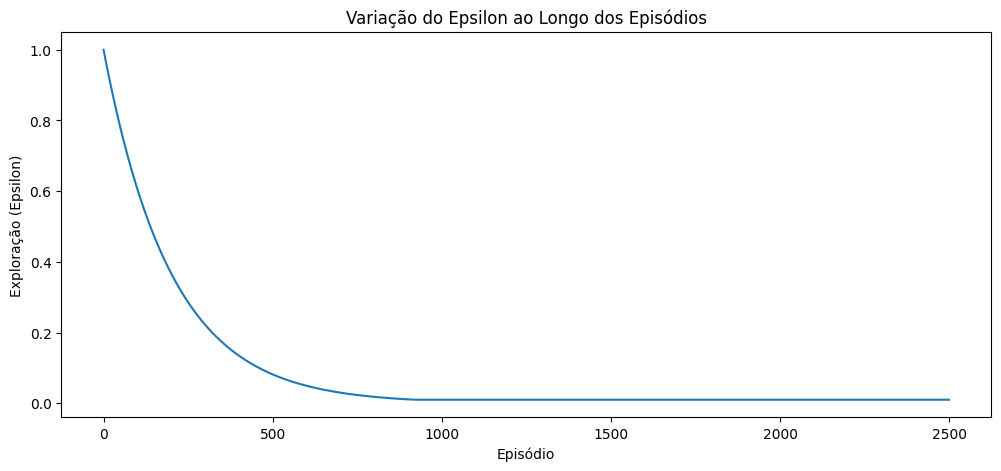

In [ ]:
# Gráfico da evolução do epsilon
plt.figure(figsize=(12, 5))
plt.plot(epsilon_values)
plt.xlabel('Episódio')
plt.ylabel('Exploração (Epsilon)')
plt.title('Variação do Epsilon ao Longo dos Episódios')
plt.show()

## 3. Faça um plot da recompensa total por número de episódios, do treinamento.

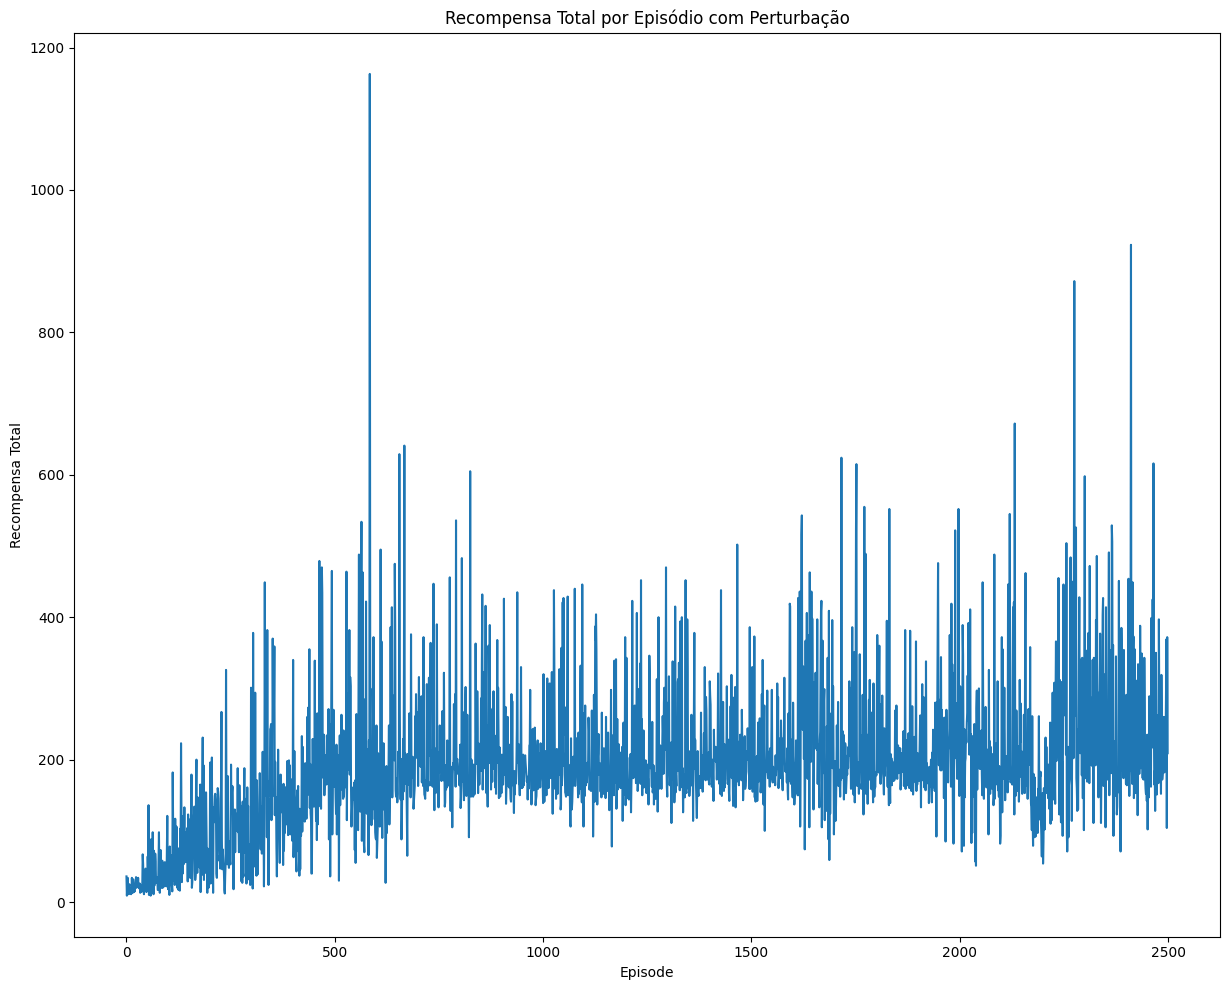

In [ ]:
plt.figure(figsize=(24, 10))
plt.subplot(1, 2, 2)
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Recompensa Total')
plt.title('Recompensa Total por Episódio com Perturbação')

plt.tight_layout()
plt.show()

## 4. Após o treinamento da Q-table, atingindo a estabilidade do CartPole faça o seguinte experimento e mostre os seguintes resultados:

  ###   i, ii, iii, iv. Inicie um novo episódio e nos 100 primeiros passos faça o controle ótimo com a Q-table treinada. Dê 5 passos na simulação com ação fixa em 1: Carro para direito, simulando uma perturbação. Complete os 500 passos utilizando a Q-table treinada novamente. Registre os resultados e faça um plot do ângulo e velocidade angular ao longo da simulação. Identifique a incidência da perturbação e o retorno à estabilidade do sistema.

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


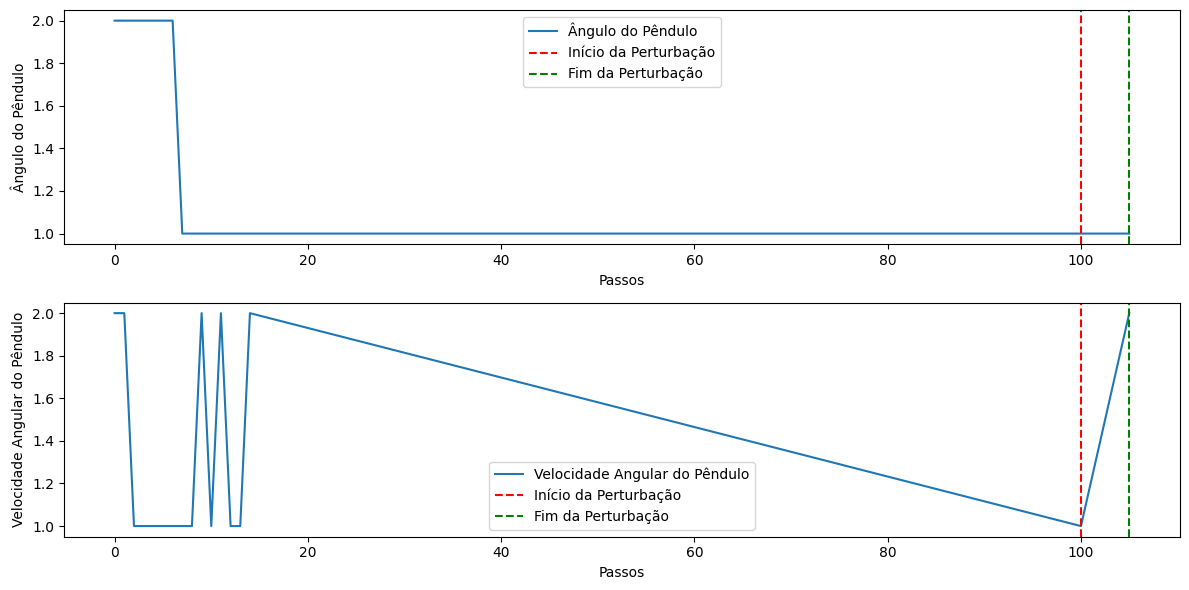

In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Função para discretizar o estado
def discretize_state(state, bins):
    state_discretized = []
    for i in range(len(state)):
        state_discretized.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(state_discretized)

# Função para escolher a ação
def choose_action(state, Q, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(env.action_space.n)  # ação aleatória
    else:
        return np.argmax(Q[state])  # ação ótima

# Função para atualizar a Q-table
def update_q_table(Q, state, action, reward, next_state, alpha, gamma):
    best_next_action = np.argmax(Q[next_state])
    td_target = reward + gamma * Q[next_state][best_next_action]
    td_error = td_target - Q[state][action]
    Q[state][action] += alpha * td_error

# Parâmetros de discretização
n_bins = 6  # Número de estados para cada variável (pode ser ajustado)
bins = [
    np.linspace(-4.8, 4.8, n_bins),  # Cart Position
    np.linspace(-4, 4, n_bins),  # Cart Velocity
    np.linspace(-0.418, 0.418, n_bins),  # Pole Angle
    np.linspace(-4, 4, n_bins)  # Pole Angular Velocity
]

# Inicialização do ambiente e da Q-table
env = gym.make('CartPole-v1', render_mode='rgb_array')
state_space_size = tuple([len(bins[i]) + 1 for i in range(len(bins))])
action_space_size = env.action_space.n
Q = np.zeros(state_space_size + (action_space_size,))

# Parâmetros de treinamento
alpha = 0.1
gamma = 0.99
epsilon_zero = 1.0
epsilon_min = 0.1
episodes = 10000
min_epsilon_episode = 8000
max_steps = 500
epsilon_decay = (epsilon_min - epsilon_zero) / min_epsilon_episode
epsilon = epsilon_zero

# Treinamento da Q-table
for episode in range(episodes):
    state = discretize_state(env.reset()[0], bins)
    for step in range(max_steps):
        action = choose_action(state, Q, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        next_state = discretize_state(next_state, bins)
        update_q_table(Q, state, action, reward, next_state, alpha, gamma)
        state = next_state
        if done:
            break
    if episode < min_epsilon_episode:
        epsilon += epsilon_decay

# Experimento após treinamento
state = discretize_state(env.reset()[0], bins)
angles = []
angular_velocities = []
steps = []

# 100 primeiros passos com controle ótimo
for step in range(100):
    action = choose_action(state, Q, epsilon=0)
    next_state, _, done, _, _ = env.step(action)
    next_state = discretize_state(next_state, bins)
    angles.append(next_state[2])
    angular_velocities.append(next_state[3])
    steps.append(step)
    state = next_state
    if done:
        break

# Perturbação: 5 passos com ação fixa em 1
for perturbation_step in range(5):
    action = 1  # Carro para a direita
    next_state, _, done, _, _ = env.step(action)
    next_state = discretize_state(next_state, bins)
    angles.append(next_state[2])
    angular_velocities.append(next_state[3])
    steps.append(100 + perturbation_step)
    state = next_state
    if done:
        break

# Retorna ao controle ótimo
for remaining_step in range(100 + 5, 500):
    action = choose_action(state, Q, epsilon=0)
    next_state, _, done, _, _ = env.step(action)
    next_state = discretize_state(next_state, bins)
    angles.append(next_state[2])
    angular_velocities.append(next_state[3])
    steps.append(remaining_step)
    state = next_state
    if done:
        break

# Plot dos resultados
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(steps, angles, label='Ângulo do Pêndulo')
plt.axvline(x=100, color='r', linestyle='--', label='Início da Perturbação')
plt.axvline(x=105, color='g', linestyle='--', label='Fim da Perturbação')
plt.xlabel('Passos')
plt.ylabel('Ângulo do Pêndulo')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(steps, angular_velocities, label='Velocidade Angular do Pêndulo')
plt.axvline(x=100, color='r', linestyle='--', label='Início da Perturbação')
plt.axvline(x=105, color='g', linestyle='--', label='Fim da Perturbação')
plt.xlabel('Passos')
plt.ylabel('Velocidade Angular do Pêndulo')
plt.legend()

plt.tight_layout()
plt.show()


## 5. Pesquise uma topologia de rede para Deep Reinforcement Learning e descreva como utilizaria para resolver este problema: Como seriam as entradas e saídas, a arquitetura da(s) rede(s) e a função de perda.

Para resolver o problema do CartPole usando Deep Reinforcement Learning (DRL), uma arquitetura comum é a Deep Q-Network (DQN). O DQN é uma extensão do Q-learning tradicional que usa uma rede neural profunda para aproximar a função Q. Aqui está uma descrição detalhada de como essa arquitetura pode ser utilizada para o problema do CartPole:

1. Entradas e Saídas

  - Entradas:

      As entradas para a rede neural serão os estados observados do ambiente CartPole. Cada estado é representado por um vetor de quatro valores contínuos:

       - Posição do carrinho (Cart Position).
       - Velocidade do carrinho (Cart Velocity).
       - Ângulo do pêndulo (Pole Angle).
       - Velocidade angular do pêndulo (Pole Angular Velocity).

  - Saídas:

      As saídas da rede neural serão os valores Q para cada ação possível no estado dado. No caso do CartPole, existem duas ações possíveis:

       - Empurrar o carrinho para a esquerda (ação 0).
       - Empurrar o carrinho para a direita (ação 1).

  Portanto, a rede neural terá uma saída para cada ação, resultando em duas saídas no total.
2. Arquitetura da Rede Neural

      A arquitetura típica para um DQN aplicado ao problema do CartPole pode ser relativamente simples, pois o problema é de baixa dimensão. Uma rede neural com algumas camadas totalmente conectadas (fully connected layers) é geralmente suficiente. Exemplo de Arquitetura:

     - Entrada: Vetor de estado com 4 elementos.
     - Camada Oculta 1: 24 neurônios, função de ativação ReLU.
     - Camada Oculta 2: 24 neurônios, função de ativação ReLU.
     - Saída: 2 neurônios (um para cada ação), sem função de ativação.

3. Função de Perda

      A função de perda para o DQN é baseada no Bellman Equation. A perda é calculada como o erro quadrático médio (MSE) entre o valor Q estimado pela rede neural e o valor Q alvo calculado a partir da recompensa recebida e do valor Q futuro máximo.

4. Implementação do Treinamento

      A implementação do treinamento inclui o processo de experiência de replay, onde transições (estado, ação, recompensa, próximo estado) são armazenadas em um buffer de replay e amostradas aleatoriamente para treinar a rede neural. Este processo ajuda a quebrar a correlação entre amostras consecutivas e estabiliza o treinamento.

Descrição dos Parâmetros

  - Alpha (α): Taxa de aprendizado, define o quanto novos valores substituem os antigos durante o processo de atualização.
  - Gamma (γ): Fator de desconto, determina a importância de recompensas futuras em comparação com recompensas imediatas.
  - Epsilon (ε): Taxa de exploração, define a probabilidade de escolher uma ação aleatória em vez da ação ótima.

Experimento de Perturbação

Para realizar o experimento de perturbação conforme descrito, o mesmo código pode ser adaptado para incluir os passos específicos da perturbação após os primeiros 100 passos controlados pela Q-table treinada.

Este método de Deep Reinforcement Learning pode ser aplicado com sucesso para resolver o problema do CartPole, garantindo um controle eficiente e robusto, mesmo diante de perturbações.
